# Projet : Détection de Spam (Classification d’emails)



Ce notebook présente un projet de détection automatique de spams à partir du contenu textuel d’emails.
L’objectif est de construire une chaîne complète de traitement de bout en bout : du nettoyage du texte jusqu’à l’évaluation de plusieurs modèles de classification.

**Dataset :** *Spam Classification for Basic NLP (Kaggle)*
https://www.kaggle.com/datasets/chandramouli_naidu/spam-classification-for-basic-nlp

---

## Contexte

Les spams (publicités non sollicitées, tentatives d’arnaques, phishing, etc.) représentent une part importante du trafic email.
Un classifieur automatique permet :
- de filtrer les messages indésirables,
- de réduire le risque de fraude,
- et d’améliorer la productivité (moins de tri manuel).

Ce projet se concentre sur une approche **NLP classique**, en transformant le texte en caractéristiques exploitables par des modèles de Machine Learning.

---

## Objectifs du projet

1. **Nettoyer le texte brut** (emails) : suppression des éléments inutiles (balises, ponctuation, caractères spéciaux, etc.)
2. **Transformer le texte en données exploitables** (vectorisation)
3. **Créer des variables simples mais efficaces** (longueur, nombre de mots, etc.)
4. **Gérer les valeurs aberrantes (outliers)** pouvant biaiser l’analyse
5. **Visualiser les données** avant modélisation afin de mieux comprendre la distribution et les différences entre classes
6. **Entraîner et comparer plusieurs modèles** (ex. SVM, réseau de neurones, LSTM)
7. **Évaluer les performances** via Accuracy, Precision, Recall et F1-score

---

## Plan du notebook

- Import des librairies
- Chargement et exploration du dataset
- Prétraitement et nettoyage du texte
- Feature engineering + vectorisation (TF-IDF)
- Modélisation (SVM / MLP / LSTM)
- Évaluation et comparaison des résultats



---
# 1. Import des librairies

Cette cellule sert à préparer l’environnement Python.
Elle importe toutes les bibliothèques qui seront utilisées dans le notebook.

Aucune donnée n’est encore chargée ni modifiée à ce stade.
Si une erreur apparaît ici (module introuvable), le notebook ne pourra pas s’exécuter.

Les bibliothèques `re` et `unicodedata` sont utilisées plus tard pour nettoyer le texte
(accents, caractères spéciaux, motifs comme les URL).
`nltk` et `emoji` servent au traitement du langage naturel.
`pandas` et `numpy` sont utilisés pour manipuler les données.
`matplotlib` et `seaborn` servent uniquement à produire des graphiques.


In [500]:
import re
import unicodedata
import emoji
import nltk

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns



pd.set_option("display.max_colwidth", 300)
sns.set(style="whitegrid")

---
<br><br>

# 2. Chargement du dataset

Le fichier est lu depuis le disque et stocké dans un DataFrame pandas appelé `df`.
À partir de ce moment, toutes les cellules suivantes utilisent `df` comme base de travail.

In [501]:
df = pd.read_csv("Spam Email raw text for NLP.csv", encoding="utf-8")
df.head()

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at their lowest point in 40 years!\n\n\n\nWe help you find the best rate for your situation by\n\nmatching your needs with hundreds of lenders!\n\n\n\nHome Improvement, Refinance, Second Mortgage,\n\nHome Equity Loans, and More! Even with less than\n\np...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Users!!!\n\n\n\n*NEW-Special Package Deal!*\n\n\n\nNorton SystemWorks 2002 Software Suite -Professional Edition-\n\n\n\nIncludes Six - Yes 6! - Feature-Packed Utilities\n\nALL For 1 Special LOW Price!\n\n\n\nThis Software Will:\n\n- Protect your compute...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,"This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset=""Windows-1252""\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n - 5.40% Guaranteed for 6 ...",00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,"IMPORTANT INFORMATION:\n\n\n\nThe new domain names are finally available to the general public at discount prices. Now you can register one of the exciting new .BIZ or .INFO domain names, as well as the original .COM and .NET names for just $14.95. These brand new domain extensions were recently...",00210.050ffd105bd4e006771ee63cabc59978
4,1,"This is the bottom line. If you can GIVE AWAY CD's for FREE to people (like 80-100 in one month) and then let ME talk to them FOR you - if you can GIVE AWAY free product samples - then YOU can earn $5,000 in the next 30 - 45 days.\n\n\n\nThink I'm kidding? We earned PRECISELY $26,087.58 in ou...",00033.9babb58d9298daa2963d4f514193d7d6


---
<br><br>
# 3. Exploration de données

Ce bloc permet de comprendre la structure du dataset.

Il affiche :
`df.head()` affiche les premières lignes pour voir à quoi ressemblent les données.
`df.info()` montre les colonnes, leurs types et le nombre de valeurs non nulles.
`df.describe()` calcule des statistiques simples pour les colonnes numériques.

Ces commandes servent uniquement à vérifier que les données sont cohérentes
avant de commencer toute transformation.



In [502]:
df.shape

(5796, 3)

<br><br>
### Vérification du schéma des données (df.info)

But : voir les colonnes, les types, et repérer tout problème (types objets, valeurs manquantes).


In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CATEGORY   5796 non-null   int64 
 1   MESSAGE    5796 non-null   object
 2   FILE_NAME  5796 non-null   object
dtypes: int64(1), object(2)
memory usage: 136.0+ KB


<br><br>
### Valeurs manquantes (NA)

Compter les valeurs manquantes par colonne.

In [504]:
df.isna().sum()

CATEGORY     0
MESSAGE      0
FILE_NAME    0
dtype: int64

<br><br>
### Distribution Spam vs Non-Spam

Ce bloc calcule et affiche le nombre d’emails par classe.

Le but est de vérifier si le dataset est équilibré ou non.
Un fort déséquilibre peut fausser les résultats d’un modèle de classification.

Le code lit uniquement la colonne de label et ne modifie aucune donnée.
Il sert à comprendre le contexte global avant d’aller plus loin.


In [505]:
df['CATEGORY'].value_counts()


CATEGORY
0    3900
1    1896
Name: count, dtype: int64

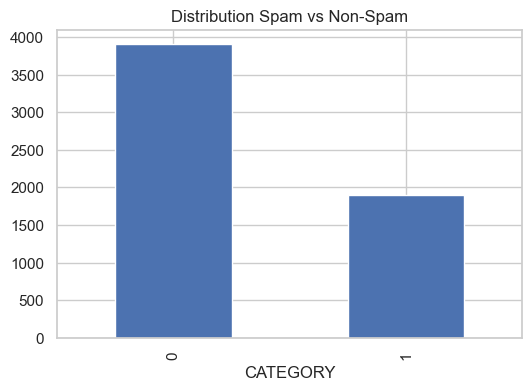

In [506]:
df['CATEGORY'].value_counts().plot(kind='bar', figsize=(6,4), title="Distribution Spam vs Non-Spam")
plt.show()

<br><br>
#### Équilibrage du dataset

Le jeu de données initial présentait un déséquilibre entre les classes *Spam* et *Not spam*.

Afin de limiter le biais du modèle, un sous-échantillonnage de la classe majoritaire a été appliqué. Les deux classes ont ensuite été fusionnées et mélangées aléatoirement pour obtenir un dataset équilibré.


In [507]:
import pandas as pd

# Séparer les classes
df_spam = df[df["CATEGORY"] == 1]
df_not_spam = df[df["CATEGORY"] == 0]

# Taille minimale entre les deux classes
min_size = min(len(df_spam), len(df_not_spam))

# Sous-échantillonnage
df_spam_down = df_spam.sample(n=min_size, random_state=42)
df_not_spam_down = df_not_spam.sample(n=min_size, random_state=42)

# Fusion
df_balanced = pd.concat(
    [df_spam_down, df_not_spam_down],
    axis=0
)

# Shuffle
df_balanced = df_balanced.sample(
    frac=1,
    random_state=42
).reset_index(drop=True)

# Remplacement
df = df_balanced

# Vérification
print(df["CATEGORY"].value_counts())


CATEGORY
1    1896
0    1896
Name: count, dtype: int64


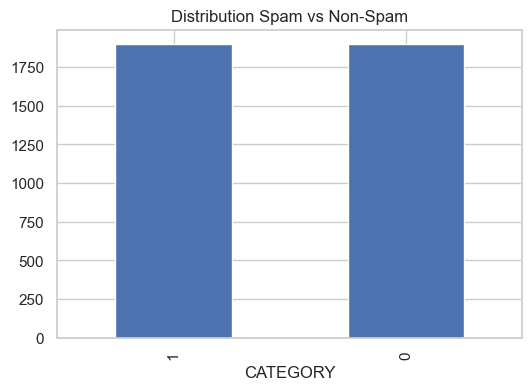

In [508]:
df['CATEGORY'].value_counts().plot(kind='bar', figsize=(6,4), title="Distribution Spam vs Non-Spam")
plt.show()

<br><br>
#### Longueur des messages

On calcule la longueur de chaque email (nombre de caractères ou de mots selon la cellule).

Selon le code, la longueur peut correspondre au nombre de caractères ou au nombre de mots dans le message. Une nouvelle colonne est ajoutée au DataFrame.

Cette information est très utile car les emails spam ont souvent une longueur différente des emails normaux.



In [509]:
df["message_length"] = df["MESSAGE"].astype(str).apply(len)
df["message_length"].describe()

count      3792.000000
mean       3406.868143
std        8034.508913
min          36.000000
25%         753.750000
50%        1411.500000
75%        3283.500000
max      234358.000000
Name: message_length, dtype: float64

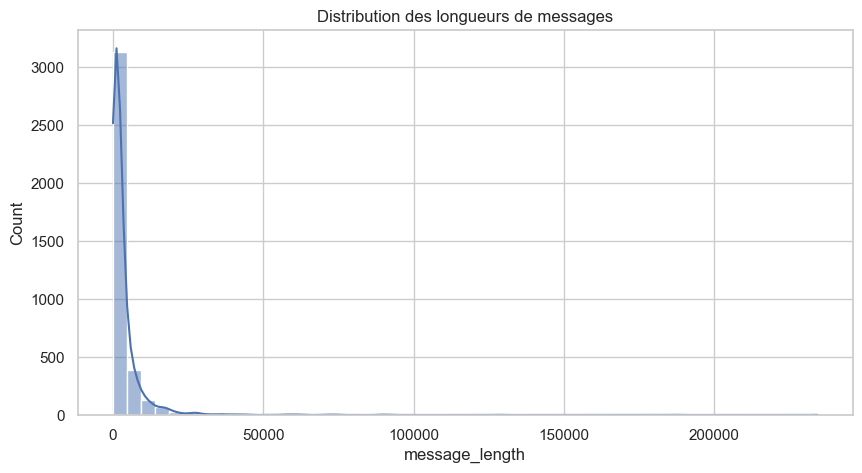

In [510]:
plt.figure(figsize=(10,5))
sns.histplot(df["message_length"], bins=50, kde=True)
plt.title("Distribution des longueurs de messages")
plt.show()

<br><br>
#### Exemples de messages

In [511]:
df['MESSAGE'].iloc[0]

'<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D"4"><B> A man endowed with a 7 - 8" hammer is simply<br>\n\n better equipped than a man with a 5 - 6" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It\'s totally up<br>to you. Our Methods are guaranteed to incre=\n\nase your size by 1 - 3"<br> <A HREF=3D"http://202.109.114.136/index.php?10=\n\n004">Enter here and see how</A>\n\n</BODY>\n\n</HTML>\n\n\n\n\n\n\n\n\n'

In [512]:
df['MESSAGE'].iloc[1]

'\n\n>>> Tim Peters wrote\n\n> We\'ve not only reduced the f-p and f-n rates in my test runs, we\'ve also\n\n> made the score distributions substantially sharper.  This is bad news for\n\n> Greg, because the non-existent "middle ground" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I\'ve finally got around to pulling down the SF code. Starting\n\nwith it, and absolutely zero local modifications, I see the following:\n\n\n\nHam distribution for all runs:\n\n* = 589 items\n\n  0.00 35292 ************************************************************\n\n  2.50    36 *\n\n  5.00    21 *\n\n  7.50    12 *\n\n 10.00     6 *\n\n 12.50     9 *\n\n 15.00     6 *\n\n 17.50     3 *\n\n 20.00     8 *\n\n 22.50     5 *\n\n 25.00     3 *\n\n 27.50    18 *\n\n 30.00     9 *\n\n 32.50     1 *\n\n 35.00     4 *\n\n 37.50     3 *\n\n 40.00     0 \n\n 42.50     3 *\n\n 45.00     3 *\n\n 47.50     4 *\n\n 50.00     9 *\n\n 52.50     5 *\n\n 55.00     5 *\n\n 57.50     3 *\n\n 60.00     4 *\n\n 62

<br><br>

#### Détection des messages contenant du HTML

On utilise des expressions régulières pour détecter des motifs particuliers dans le texte, comme la présence de HTML.

Les spams contiennent souvent des balises HTML ou du code formaté, ce qui peut être un signal intéressant.

Le code parcourt le texte et marque les emails correspondants.


In [513]:
df["has_html"] = df["MESSAGE"].str.contains("<.*?>")
df["has_html"].value_counts()

has_html
False    2161
True     1631
Name: count, dtype: int64

In [514]:
#pattern = "00487.139a2f4e8edbbdd64441536308169d74"
pattern = ""

if pattern.strip() != "":
    df = df[df["FILE_NAME"].str.contains(pattern, na=False)]
else:
    print("Pattern vide → aucun filtre appliqué.")



Pattern vide → aucun filtre appliqué.


---
<br><br><br>
# 4. Normalisation
Pipeline de normalisation du texte afin de préparer les messages à l’analyse NLP et à la classification Spam / Non-Spam :

- Suppression des balises HTML.
- Transformation des emojis en texte.
- Remplacement des URLs par un token.
- Tentative de décodage des chaînes Base64.
- Suppression des chaînes alphanumériques suspects (tracking).
- Suppression des métadonnées MIME (headers techniques d’email).
- Normalisation Unicode + suppression des accents.
- Fusion des sigles : ex. U.S.A. → USA.
- Transformation des emails en mots séparés.
- Suppression des espaces invisibles et caractères spéciaux.
- Nettoyage final : lettres uniquement, réduction des répétitions et espaces.
- Mise en minuscules du texte nettoyé.

In [515]:
import re
import unicodedata
import base64
import emoji


# --------------------------------------------------
# Remove MIME / email headers aggressively
# --------------------------------------------------
def remove_mime(text):
    text = re.sub(
        r"-{2,}[_A-Za-z0-9=]+(?:NextPart|Part|boundary)[A-Za-z0-9_=.-]*",
        " ",
        text,
        flags=re.I
    )
    text = re.sub(
        r"^(content|mime|multipart|boundary|return|delivered|message-id|x-[a-z\-]+)[^\n]*",
        " ",
        text,
        flags=re.I | re.M
    )
    return text


# --------------------------------------------------
# Emojis → words
# --------------------------------------------------
def demojize_words(text):
    text = emoji.demojize(text)
    text = re.sub(
        r":([a-zA-Z0-9_]+):",
        lambda m: " " + m.group(1).replace("_", " ") + " ",
        text
    )
    return text


# --------------------------------------------------
# Main cleaning function
# --------------------------------------------------
def clean_text(text):

    text = str(text)

    # Emojis
    text = demojize_words(text)

    # HTML tags and entities
    text = re.sub(r"<[^<>]*?>", " ", text)
    text = re.sub(r"&[a-zA-Z0-9#]+;", " ", text)

    # URLs
    text = re.sub(r"https?://\S+", " ", text)
    text = re.sub(r"www\.\S+", " ", text)

    # Tracking strings (letters + digits)
    text = re.sub(r"\b(?=.*[A-Za-z])(?=.*\d)[A-Za-z0-9]{6,}\b", " ", text)

    # Base64 decoding (safe)
    def try_decode_b64(s):
        try:
            decoded = base64.b64decode(s).decode("utf-8", errors="ignore")
            return decoded if len(decoded) > 10 else " "
        except Exception:
            return " "

    text = re.sub(
        r"\b[A-Za-z0-9+/=]{12,}\b",
        lambda m: try_decode_b64(m.group(0)),
        text
    )

    # MIME leftovers
    text = remove_mime(text)

    # Unicode normalization + accent removal
    text = unicodedata.normalize("NFKD", text)
    text = "".join(c for c in text if not unicodedata.combining(c))

    # Remove non-ascii
    text = re.sub(r"[^\x00-\x7F]+", " ", text)

    # Split camelCase
    text = re.sub(r"([a-z])([A-Z])", r"\1 \2", text)

    # Collapse acronyms (U.S.A. → USA)
    text = re.sub(
        r"\b(?:[A-Za-z]\.){2,}",
        lambda m: m.group(0).replace(".", ""),
        text
    )

    # Emails → tokens
    EMAIL_REGEX = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b"
    text = re.sub(
        EMAIL_REGEX,
        lambda m: re.sub(r"[._@\-]", " ", m.group(0)),
        text
    )

    # Invisible spaces
    text = re.sub(r"[\u00A0\u2007\u202F\uFEFF]", " ", text)

    # Remove numbers
    text = re.sub(r"\b\d+\b", " ", text)

    # Keep letters only
    text = re.sub(r"[^A-Za-z ]", " ", text)

    # Normalize spaces
    text = re.sub(r"\s+", " ", text)

    # Lowercase + split
    words = text.lower().split()

    # --------------------------------------------------
    # FINAL LEXICAL FILTERING
    # --------------------------------------------------

    # Remove very short tokens
    words = [w for w in words if len(w) >= 3]

    # Dataset / technical noise
    TECH_TOKENS = {
        "br","rpm","exmh","listmaster","spamassassin","razor","pyzor",
        "sourceforge","mailto","http","https","www","com",
        "nbsp","ie","un","de","sf","ilug","perl","pm",
        "html","uri","url","org","cd","fax",
        "iii","ctd","ftoc","xent","enen",
        "saou","beberg","dagga","ragga",
        "kio","alb","egroups","osdn",
        "linux","gnu","kernel","redhat","unix","pgp","iso",
        "apt","gpl","gnome","admin","root","ssh",
        "mime","header","unsubscribe"
    }

    # Weak semantic verbs / fillers (recommended for WordCloud & LDA)
    WEAK_WORDS = {
        ""
    }

    words = [
        w for w in words
        if w not in TECH_TOKENS
        and w not in WEAK_WORDS
    ]

    return " ".join(words)


In [516]:
df["CLEANED"] = df["MESSAGE"].astype(str).apply(clean_text)
df.head()


,CATEGORY,MESSAGE,FILE_NAME,message_length,has_html,CLEANED
0,1,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",00350.c2658f17a328efdf045b38ab38db472f,449,True,man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how
1,0,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",01745.46a467858b1369e9513a8a369a67a70b,2536,True,tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...
2,1,"<html>\n\n<head>\n\n<title>New amazing incest show on Hot-Babies-Live.Com</title>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\n</head>\n\n<body bgcolor=#000000 text=#000000 link=#000000 vlink=#000000 alink=""#ff0000"" topmargin=0 leftmargin=0 rightmargin=0 botto...",00693.6afadd2f5d9b7fd80f4e710589b4187c,8646,True,new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time hot...
3,0,"Hiya, I just myself an rpm, and when I did -Uvh to upgrade the earlier \n\nversion I had installed (also from my rpm) I got:\n\n\n\n[root@spawn i386]# rpm -Uvh mulberry-2.2-b1.i386.rpm\n\nPreparing... ########################################### \n\n[100%]\n\n 1:mulberry ...",01088.a46067a122aa5ad5d062961e6ecb3951,862,True,hiya just myself and when did uvh upgrade the earlier version had installed also from got spawn uvh preparing mulberry error error from close incomplete cache flush was unable complete whats the incomplete mean all seems have installed thou seem super human have been dream theater mark icq jid t...
4,0,"Well, it looks like Sun are going ahead with\n\ntheir ubiquitous computing plans without Mithril. \n\n\n\nGreg\n\n\n\nReuters Market News\n\n Sun Micro Outlines Roadmap for Managing Networks \n\n Friday September 20, 5:00 am ET \n\n By Peter Henderson \n\n\n\n SAN FRANCISCO (Reuters) - Compu...",00667.dfa0ab3eb4214034892b8cda76d9d750,2542,False,well looks like sun are going ahead with their ubiquitous computing plans without mithril greg reuters market news sun micro outlines roadmap for managing networks peter henderson san francisco reuters computer maker sun inc thursday said would create few years network environment that will call...


---
<br><br><br>

# 5. Tokenisation

#### Tokenisation en phrases

Pipeline de segmentation du texte normalisé en phrases, afin de structurer le contenu des emails avant la tokenisation en mots.

Cette étape découpe chaque message en unités syntaxiques cohérentes (phrases) afin de :
- préserver la structure naturelle du langage,
- éviter de mélanger des segments sans lien logique,
- préparer des traitements NLP plus fins et contrôlés.

Fonctionnement général :
- Le texte normalisé est parcouru séquentiellement.
- Les ponctuations fortes (., !, ?) sont utilisées comme séparateurs.
- Chaque email est transformé en une liste ordonnée de phrases.

Cette étape ne modifie pas le contenu textuel mais uniquement sa structure :
- Avant : une chaîne de caractères par email.
- Après : une liste de phrases par email.

Elle est particulièrement utile pour les emails longs ou hétérogènes (marketing, signatures, mentions légales).
Si l’analyse ne nécessite pas un traitement au niveau phrase, cette étape peut être supprimée à condition d’adapter la tokenisation suivante.


In [517]:
import nltk
#from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tag import PerceptronTagger

import spacy
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

# Load spaCy English and French models
nlp_en = spacy.load("en_core_web_md")
nlp_fr = spacy.load("fr_core_news_md")

nltk.download("punkt")
nltk.download("stopwords")
nltk.download('omw-1.4')
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_dat

True

In [518]:
df["SENTENCES"] = df["CLEANED"].apply(lambda txt: sent_tokenize(txt))

df[["CLEANED", "SENTENCES"]].head()



,CLEANED,SENTENCES
0,man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,[man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how]
1,tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,[tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all run...
2,new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time hot...,[new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time ho...
3,hiya just myself and when did uvh upgrade the earlier version had installed also from got spawn uvh preparing mulberry error error from close incomplete cache flush was unable complete whats the incomplete mean all seems have installed thou seem super human have been dream theater mark icq jid t...,[hiya just myself and when did uvh upgrade the earlier version had installed also from got spawn uvh preparing mulberry error error from close incomplete cache flush was unable complete whats the incomplete mean all seems have installed thou seem super human have been dream theater mark icq jid ...
4,well looks like sun are going ahead with their ubiquitous computing plans without mithril greg reuters market news sun micro outlines roadmap for managing networks peter henderson san francisco reuters computer maker sun inc thursday said would create few years network environment that will call...,[well looks like sun are going ahead with their ubiquitous computing plans without mithril greg reuters market news sun micro outlines roadmap for managing networks peter henderson san francisco reuters computer maker sun inc thursday said would create few years network environment that will cal...


<br><br>
#### Tokenisation en mots

Pipeline de découpage des phrases en mots (tokens), base fondamentale de toute analyse NLP.

Cette étape transforme chaque phrase en une séquence de mots exploitables par :
- les statistiques de fréquence,
- les règles linguistiques,
- les modèles de machine learning.

Fonctionnement général :
- Chaque phrase est analysée indépendamment.
- Les séparateurs linguistiques sont utilisés pour isoler les mots.
- Les mots sont conservés sous forme de tokens individuels.

Structure obtenue :
- Avant : liste de phrases (chaînes de caractères).
- Après : liste de listes de tokens (mots).

Cette structure est centrale dans le pipeline NLP :
- elle conserve l’ordre des mots,
- elle prépare les étapes suivantes (filtrage, lemmatisation, modélisation).

Toute approximation à ce stade se propage à l’ensemble du pipeline.


In [519]:
df["TOKENS PRE"] = df["SENTENCES"].apply(lambda sentences: [word_tokenize(sent) for sent in sentences])
df[["CLEANED", "TOKENS PRE"]].head()



,CLEANED,TOKENS PRE
0,man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,"[[man, with, hammer, simply, than, man, with, hammer, would, you, rather, have, more, than, enough, get, the, job, done, fall, very, short, totally, you, our, methods, are, guaranteed, incre, ase, your, size, enter, here, and, see, how]]"
1,tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,"[[tim, peters, wrote, not, only, reduced, the, and, rates, test, runs, also, made, the, score, sharper, this, bad, news, for, greg, because, the, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, down, the, code, starting, with, and, absolutely, ..."
2,new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time hot...,"[[new, amazing, incest, show, hot, babies, live, age, cms, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cms, hair, color, blonde, eye, color, green, chest, size, sexual, preference, new, amazing, incest, show, hot, babies, live, hot, babies, live, new, porno, si..."
3,hiya just myself and when did uvh upgrade the earlier version had installed also from got spawn uvh preparing mulberry error error from close incomplete cache flush was unable complete whats the incomplete mean all seems have installed thou seem super human have been dream theater mark icq jid t...,"[[hiya, just, myself, and, when, did, uvh, upgrade, the, earlier, version, had, installed, also, from, got, spawn, uvh, preparing, mulberry, error, error, from, close, incomplete, cache, flush, was, unable, complete, whats, the, incomplete, mean, all, seems, have, installed, thou, seem, super, h..."
4,well looks like sun are going ahead with their ubiquitous computing plans without mithril greg reuters market news sun micro outlines roadmap for managing networks peter henderson san francisco reuters computer maker sun inc thursday said would create few years network environment that will call...,"[[well, looks, like, sun, are, going, ahead, with, their, ubiquitous, computing, plans, without, mithril, greg, reuters, market, news, sun, micro, outlines, roadmap, for, managing, networks, peter, henderson, san, francisco, reuters, computer, maker, sun, inc, thursday, said, would, create, few,..."


---
<br><br><br>
# 6. Suppression des stopwords (anglais)

Pipeline de filtrage linguistique visant à supprimer les mots très fréquents et peu informatifs.

Les stopwords correspondent à des mots fonctionnels (articles, prépositions, conjonctions) qui apparaissent dans presque tous les textes et ne permettent pas de distinguer un spam d’un email normal.

Dans ce notebook :
- seuls les stopwords anglais sont supprimés,
- la liste de stopwords est fournie par NLTK.

Effets directs :
- réduction significative du vocabulaire,
- focalisation sur les mots porteurs de sens (ex. free, offer, click).

Ce choix est structurant :
- si le dataset contient du français, ces mots ne sont pas filtrés,
- ce comportement doit être assumé ou ajusté selon le contexte.

Modifier cette étape impacte directement le vocabulaire final et les performances des modèles.




In [520]:
stop_words = set(stopwords.words("english"))

df["TOKENS"] = df["TOKENS PRE"].apply(
    lambda list_sent: [[w for w in sent if w.casefold() not in stop_words] for sent in list_sent]
)


In [521]:
df[["TOKENS PRE", "TOKENS"]].head()


,TOKENS PRE,TOKENS
0,"[[man, with, hammer, simply, than, man, with, hammer, would, you, rather, have, more, than, enough, get, the, job, done, fall, very, short, totally, you, our, methods, are, guaranteed, incre, ase, your, size, enter, here, and, see, how]]","[[man, hammer, simply, man, hammer, would, rather, enough, get, job, done, fall, short, totally, methods, guaranteed, incre, ase, size, enter, see]]"
1,"[[tim, peters, wrote, not, only, reduced, the, and, rates, test, runs, also, made, the, score, sharper, this, bad, news, for, greg, because, the, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, down, the, code, starting, with, and, absolutely, ...","[[tim, peters, wrote, reduced, rates, test, runs, also, made, score, sharper, bad, news, greg, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, code, starting, absolutely, zero, local, see, following, ham, runs, items, spam, runs, items, next, c..."
2,"[[new, amazing, incest, show, hot, babies, live, age, cms, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cms, hair, color, blonde, eye, color, green, chest, size, sexual, preference, new, amazing, incest, show, hot, babies, live, hot, babies, live, new, porno, si...","[[new, amazing, incest, show, hot, babies, live, age, cms, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cms, hair, color, blonde, eye, color, green, chest, size, sexual, preference, new, amazing, incest, show, hot, babies, live, hot, babies, live, new, porno, si..."
3,"[[hiya, just, myself, and, when, did, uvh, upgrade, the, earlier, version, had, installed, also, from, got, spawn, uvh, preparing, mulberry, error, error, from, close, incomplete, cache, flush, was, unable, complete, whats, the, incomplete, mean, all, seems, have, installed, thou, seem, super, h...","[[hiya, uvh, upgrade, earlier, version, installed, also, got, spawn, uvh, preparing, mulberry, error, error, close, incomplete, cache, flush, unable, complete, whats, incomplete, mean, seems, installed, thou, seem, super, human, dream, theater, mark, icq, jid, talios, myjabber, net, list, mailin..."
4,"[[well, looks, like, sun, are, going, ahead, with, their, ubiquitous, computing, plans, without, mithril, greg, reuters, market, news, sun, micro, outlines, roadmap, for, managing, networks, peter, henderson, san, francisco, reuters, computer, maker, sun, inc, thursday, said, would, create, few,...","[[well, looks, like, sun, going, ahead, ubiquitous, computing, plans, without, mithril, greg, reuters, market, news, sun, micro, outlines, roadmap, managing, networks, peter, henderson, san, francisco, reuters, computer, maker, sun, inc, thursday, said, would, create, years, network, environment..."


---
<br><br><br>
# 7. Lemmatisation

#### Préparation à la lemmatisation (analyse grammaticale)


Étape de préparation linguistique nécessaire à une lemmatisation précise.

Avant de réduire un mot à sa forme canonique, il est indispensable d’identifier sa catégorie grammaticale :
- nom,
- verbe,
- adjectif,
- adverbe.

Cette étape :
- analyse chaque token,
- lui associe un Part-Of-Speech (POS tag),
- prépare un mapping compatible avec WordNet ou spaCy.

Sans cette étape, la lemmatisation devient approximative car un même mot peut avoir plusieurs lemmes selon son rôle grammatical.

Cette couche linguistique améliore la qualité du traitement, au prix d’un coût computationnel plus élevé.


In [522]:
import spacy
nlp_en = spacy.load("en_core_web_sm")

# Liste complète des pronoms à NE PAS lemmatiser
PRONOUNS = {
    "i","you","he","she","it","we","they",
    "me","him","her","us","them",
    "my","your","his","its","our","their",
    "mine","yours","hers","ours","theirs"
}


<br><br>
#### Lemmatisation des tokens

Pipeline de réduction morphologique visant à ramener chaque mot à sa forme canonique (lemme).

Exemples :
- running → run
- cars → car
- better → good

Fonctionnement général :
- chaque token est analysé avec son tag grammatical,
- le lemme correspondant est identifié,
- le token est remplacé par sa forme canonique.

Effets :
- réduction importante de la taille du vocabulaire,
- regroupement des variantes morphologiques,
- meilleure généralisation des modèles de classification.

Limites :
- perte de certaines nuances sémantiques,
- coût en temps de calcul,
- utilité discutable pour des tâches simples comme la détection de spam.

Cette étape est optionnelle mais fortement structurante.


In [523]:

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import PerceptronTagger

lemmatizer_en = WordNetLemmatizer()
tagger_en = PerceptronTagger(lang="eng")



def get_wordnet_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    return wordnet.NOUN


def lemmatize_english(words):
    tagged_words = tagger_en.tag(words)
    lemmas = []

    for word, pos in tagged_words:
        w = word.lower()

        # ❗ IMPORTANT : ne pas modifier les pronoms
        if w in PRONOUNS:
            lemmas.append(w)
            continue

        # Lemmatisation normale
        wn_pos = get_wordnet_pos(pos)
        lemma = lemmatizer_en.lemmatize(w, wn_pos)
        lemmas.append(lemma)

    return lemmas



In [524]:
df["LEMMAS"] = df["TOKENS"].apply(
    lambda sentences: [lemmatize_english(sent) for sent in sentences]
)

df[["MESSAGE", "CLEANED", "LEMMAS"]].head()



,MESSAGE,CLEANED,LEMMAS
0,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,"[[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]]"
1,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,"[[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, compl..."
2,"<html>\n\n<head>\n\n<title>New amazing incest show on Hot-Babies-Live.Com</title>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\n</head>\n\n<body bgcolor=#000000 text=#000000 link=#000000 vlink=#000000 alink=""#ff0000"" topmargin=0 leftmargin=0 rightmargin=0 botto...",new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time hot...,"[[new, amaze, incest, show, hot, baby, live, age, cm, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cm, hair, color, blonde, eye, color, green, chest, size, sexual, preference, new, amaze, incest, show, hot, baby, live, hot, baby, live, new, porno, site, see, por..."
3,"Hiya, I just myself an rpm, and when I did -Uvh to upgrade the earlier \n\nversion I had installed (also from my rpm) I got:\n\n\n\n[root@spawn i386]# rpm -Uvh mulberry-2.2-b1.i386.rpm\n\nPreparing... ########################################### \n\n[100%]\n\n 1:mulberry ...",hiya just myself and when did uvh upgrade the earlier version had installed also from got spawn uvh preparing mulberry error error from close incomplete cache flush was unable complete whats the incomplete mean all seems have installed thou seem super human have been dream theater mark icq jid t...,"[[hiya, uvh, upgrade, earlier, version, instal, also, get, spawn, uvh, prepare, mulberry, error, error, close, incomplete, cache, flush, unable, complete, whats, incomplete, mean, seem, instal, thou, seem, super, human, dream, theater, mark, icq, jid, talios, myjabber, net, list, mailing, list]]"
4,"Well, it looks like Sun are going ahead with\n\ntheir ubiquitous computing plans without Mithril. \n\n\n\nGreg\n\n\n\nReuters Market News\n\n Sun Micro Outlines Roadmap for Managing Networks \n\n Friday September 20, 5:00 am ET \n\n By Peter Henderson \n\n\n\n SAN FRANCISCO (Reuters) - Compu...",well looks like sun are going ahead with their ubiquitous computing plans without mithril greg reuters market news sun micro outlines roadmap for managing networks peter henderson san francisco reuters computer maker sun inc thursday said would create few years network environment that will call...,"[[well, look, like, sun, 

<br><br>
Étape de reconstruction visant à repasser d’une représentation tokenisée à une représentation textuelle exploitable.

Après tokenisation, filtrage et lemmatisation :
- les tokens sont regroupés,
- le texte est reconstruit sous forme de chaînes nettoyées.

Objectif :
- produire un texte final prêt pour :
  - TF-IDF,
  - Bag-of-Words,
  - embeddings,
  - modèles de classification.

Cette étape marque la fin du pipeline de prétraitement NLP.
Toutes les analyses et modélisations ultérieures reposent directement sur ce texte reconstruit.


In [525]:
# 3) Flatten de LEMMAS_EN (qui est une liste de listes)
df["TOKENS FINAL"] = df["LEMMAS"].apply(
    lambda sent_list: [w for sentence in sent_list for w in sentence]
)

# 4) Version texte des lemmes pour les embeddings textuels
df["LEMMAS_TEXT"] = df["TOKENS FINAL"].apply(lambda tokens: " ".join(tokens))

df[["MESSAGE", "CLEANED", "TOKENS", "LEMMAS", "TOKENS FINAL", "LEMMAS_TEXT"]].head()



,MESSAGE,CLEANED,TOKENS,LEMMAS,TOKENS FINAL,LEMMAS_TEXT
0,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,"[[man, hammer, simply, man, hammer, would, rather, enough, get, job, done, fall, short, totally, methods, guaranteed, incre, ase, size, enter, see]]","[[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]]","[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]",man hammer simply man hammer would rather enough get job do fall short totally method guarantee incre ase size enter see
1,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,"[[tim, peters, wrote, reduced, rates, test, runs, also, made, score, sharper, bad, news, greg, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, code, starting, absolutely, zero, local, see, following, ham, runs, items, spam, runs, items, next, c...","[[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, compl...","[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, comple...",tim peter write reduce rate test run also make score sharper bad news greg non existent middle ground become even less existent well finally get around pull code start absolutely zero local see follow ham run item spam run item next current task complete corpus get currently get ham spam current...
2,"<html>\n\n<head>\n\n<title>New amazing incest show on Hot-Babies-Live.Com</title>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\n</head>\n\n<body bgcolor=#000000 text=#000000 link=#000000 vlink=#000000 alink=""#ff0000"" topmargin=0 leftmargin=0 rightmargin=0 botto...",new amazing incest show hot babies live age cms hair color brunette eye color blue chest size sexual preference age cms hair color blonde eye color green chest size sexual preference new amazing incest show hot babies live hot babies live new porno site where you can see porno show real time hot...,"[[new, amazing, incest, show, hot, babies, live, age, cms, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cms, hair, color, blonde, eye, color, green, chest, size, sexual, preference, new, amazing, incest, show, hot, babies, live, hot, babies, live, new, porno, si...","[[new, amaze, incest, show, hot, baby, live, age, cm, hair, color, brunette, eye, color, blue, chest, size, sexual, preference, age, cm, hair, color, 

In [526]:
df



,CATEGORY,MESSAGE,FILE_NAME,message_length,has_html,CLEANED,SENTENCES,TOKENS PRE,TOKENS,LEMMAS,TOKENS FINAL,LEMMAS_TEXT
0,1,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",00350.c2658f17a328efdf045b38ab38db472f,449,True,man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,[man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how],"[[man, with, hammer, simply, than, man, with, hammer, would, you, rather, have, more, than, enough, get, the, job, done, fall, very, short, totally, you, our, methods, are, guaranteed, incre, ase, your, size, enter, here, and, see, how]]","[[man, hammer, simply, man, hammer, would, rather, enough, get, job, done, fall, short, totally, methods, guaranteed, incre, ase, size, enter, see]]","[[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]]","[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]",man hammer simply man hammer would rather enough get job do fall short totally method guarantee incre ase size enter see
1,0,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",01745.46a467858b1369e9513a8a369a67a70b,2536,True,tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,[tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all run...,"[[tim, peters, wrote, not, only, reduced, the, and, rates, test, runs, also, made, the, score, sharper, this, bad, news, for, greg, because, the, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, down, the, code, starting, with, and, absolutely, ...","[[tim, peters, wrote, reduced, rates, test, runs, also, made, score, sharper, bad, news, greg, non, existent, middle, ground, becoming, even, less, existent, well, finally, got, around, pulling, code, starting, absolutely, zero, local, see, following, ham, runs, items, spam, runs, items, next, c...","[[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, compl...","[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, comple...",tim peter write reduce rate test run also make score sharper bad news greg non existent middle ground become even less existent well finally get around pull

---
<br><br><br>
# 8. Embedding

Pipeline de transformation du texte nettoyé en représentations numériques exploitables par des algorithmes de machine learning.

Le texte ne peut pas être utilisé directement par un modèle :
il doit être converti en vecteurs numériques de taille fixe.

Pour cela, nous utilisons plusieurs types d'« embeddings » :

1. **Bag of Words (CountVectorizer)**
   Représentation basée sur le nombre d'occurrences de chaque mot dans chaque document.

2. **TF-IDF (Term Frequency – Inverse Document Frequency)**
   Pondération qui valorise les mots fréquents dans un document mais rares dans le corpus.

3. **Word2Vec (moyenne des vecteurs de mots)**
   Modèle qui apprend une représentation dense pour chaque mot, puis on calcule un vecteur moyen par mail.

4. **BERT (Sentence Embeddings)**
   Modèle de langage pré-entraîné qui produit un vecteur dense pour chaque mail (prise en compte du contexte).

Résultat :
- chaque email est représenté par un vecteur numérique,
- tous les emails ont la même dimension.

Cette étape est déterminante car elle conditionne directement la performance du modèle de classification.

In [527]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import numpy as np

# ============================
# 0. Base text for embeddings
# ============================

# Text version: one string per mail
text_series = df["LEMMAS_TEXT"].astype(str)

# Token lists: one list of tokens per mail (déjà filtrés)
tokens_series = df["TOKENS FINAL"]

<br><br>
#### 1) Bag of Words (BoW)

Ici, chaque email est représenté par un vecteur où chaque dimension correspond à un mot du vocabulaire.

Le code :
- crée un `CountVectorizer()` sans paramètres spécifiques,
- apprend le vocabulaire sur `text_series` via `fit_transform`,
- produit une matrice creuse `X_bow` de forme (n_emails, n_mots),
- stocke ensuite, pour chaque email, sa ligne vectorisée dans `df["BOW"]`.

Interprétation :
- `X_bow.shape` te dit combien d’emails et combien de mots uniques ont été conservés.
- BoW ignore l’ordre des mots : seul le comptage compte.

Point d’attention : stocker des objets “sparse row” dans une colonne `df["BOW"]` peut être pratique pour l’exploration, mais ce n’est pas toujours optimal pour entraîner un modèle (on préfère garder la matrice `X_bow` à part).


In [528]:
# ============================
# 1. Bag of Words
# ============================

bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(text_series)

print("Bag of Words shape:", X_bow.shape)

# Stocker dans le df (une ligne = un vecteur sparse)
df["BOW"] = [X_bow[i] for i in range(X_bow.shape[0])]


Bag of Words shape: (3792, 26920)


<br><br>
#### 2) TF-IDF

TF-IDF est une variante de BoW qui pondère les mots selon leur importance.

Le code :
- crée un `TfidfVectorizer()` sans paramètres spécifiques,
- apprend et transforme `text_series` via `fit_transform`,
- produit une matrice creuse `X_tfidf`,
- stocke ensuite chaque ligne dans `df["TFIDF"]`.

Intuition :
- un mot très fréquent dans un email mais rare dans le corpus reçoit un poids élevé,
- un mot présent partout reçoit un poids faible.

Dans un problème spam / non-spam, TF-IDF est souvent un excellent “baseline” très difficile à battre.

Comme pour BoW, si on veut ajuster la vectorisation (ngram_range, min_df, max_df…), c’est dans `TfidfVectorizer(...)` que ça se fait.



In [529]:
# ============================
# 2. TF-IDF
# ============================

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(text_series)

print("TF-IDF shape:", X_tfidf.shape)

df["TFIDF"] = [X_tfidf[i] for i in range(X_tfidf.shape[0])]


TF-IDF shape: (3792, 26920)


<br><br>
### 3) Word2Vec (embeddings d’email par moyenne)

On apprend d’abord un modèle Word2Vec sur tes tokens, puis on transforme chaque email en vecteur dense.

Étape 1 : apprentissage Word2Vec
- `sentences_for_w2v = tokens_series.tolist()` fournit la liste des emails sous forme de listes de tokens.
- `Word2Vec(...)` apprend un vecteur pour chaque mot (dimension `vector_size=100`).

Paramètres importants (ceux de ton code) :
- `vector_size=100` : taille des vecteurs.
- `window=5` : contexte de mots autour.
- `min_count=2` : ignore les mots trop rares (moins de 2 occurrences).
- `workers=4` : parallélisation.

Étape 2 : vecteur d’email (doc embedding)
- La fonction `doc_vector_w2v(...)` garde uniquement les tokens connus du modèle.
- Si aucun token n’est connu, elle renvoie un vecteur de zéros.
- Sinon, elle calcule la moyenne des vecteurs des mots (simple et efficace).

Enfin :
- `X_w2v` devient une matrice dense (n_emails, 100),
- et `df["W2V"]` stocke un vecteur dense par email.

Point d’attention : Word2Vec appris “sur ton corpus” peut être faible si le dataset est petit. C’est normal, et c’est l’une des raisons pour lesquelles TF-IDF peut mieux marcher en spam.



In [530]:
# ============================
# 3. Word2Vec (doc embeddings)
# ============================

sentences_for_w2v = tokens_series.tolist()

w2v_model = Word2Vec(
    sentences=sentences_for_w2v,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

def doc_vector_w2v(tokens, model, vector_size=100):
    valid_tokens = [w for w in tokens if w in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    return np.mean(model.wv[valid_tokens], axis=0)

X_w2v = np.vstack([
    doc_vector_w2v(tokens, w2v_model, w2v_model.vector_size)
    for tokens in tokens_series
])

print("Word2Vec doc embeddings shape:", X_w2v.shape)

df["W2V"] = list(X_w2v)



Word2Vec doc embeddings shape: (3792, 100)


<br><br>
#### 4) BERT (sentence embeddings)

On génère un embedding dense pour chaque email avec un modèle pré-entraîné SentenceTransformers.

Le code :
- charge `SentenceTransformer("all-MiniLM-L6-v2")`,
- encode tous les emails via `bert_model.encode(...)`,
- produit `X_bert` (n_emails, dim_embedding),
- stocke ensuite chaque vecteur dans `df["BERT"]`.

Détails pratiques :
- `batch_size=32` gère le débit de calcul.
- `show_progress_bar=True` affiche une barre de progression.
- `all-MiniLM-L6-v2` est rapide et compact (bon compromis vitesse/qualité).

Point d’attention : cette étape est la plus coûteuse (temps + mémoire). Stocker BERT dans `df` peut rendre le notebook lourd. Si on ne l’utilise pas ensuite, garde plutôt `X_bert` séparément.

Si on veut changer de modèle (plus précis ou plus lourd), c’est la chaîne dans `SentenceTransformer("...")` qu’il faut modifier.


In [531]:

# ============================
# 4. BERT (sentence embeddings)
# ============================

bert_model = SentenceTransformer("all-MiniLM-L6-v2")

X_bert = bert_model.encode(text_series.tolist(), batch_size=32, show_progress_bar=True)
X_bert = np.array(X_bert)

print("BERT embeddings shape:", X_bert.shape)

df["BERT"] = list(X_bert)

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

BERT embeddings shape: (3792, 384)


In [532]:

df[[
    "MESSAGE",
    "CLEANED",
    "TOKENS FINAL",
    "LEMMAS_TEXT",
    "BOW",
    "TFIDF",
    "W2V",
    "BERT"
]].head()


,MESSAGE,CLEANED,TOKENS FINAL,LEMMAS_TEXT,BOW,TFIDF,W2V,BERT
0,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",man with hammer simply than man with hammer would you rather have more than enough get the job done fall very short totally you our methods are guaranteed incre ase your size enter here and see how,"[man, hammer, simply, man, hammer, would, rather, enough, get, job, do, fall, short, totally, method, guarantee, incre, ase, size, enter, see]",man hammer simply man hammer would rather enough get job do fall short totally method guarantee incre ase size enter see,"(0, 14350)\t2\n (0, 10294)\t2\n (0, 21631)\t1\n (0, 26259)\t1\n (0, 19347)\t1\n (0, 7541)\t1\n (0, 9602)\t1\n (0, 12545)\t1\n (0, 6509)\t1\n (0, 8272)\t1\n (0, 21479)\t1\n (0, 24013)\t1\n (0, 14834)\t1\n (0, 10129)\t1\n (0, 11606)\t1\n (0, 1554)\t1\n (0, 21714)\t1\n (0, 7569)\...","(0, 14350)\t0.35770711162689417\n (0, 10294)\t0.553279956330176\n (0, 21631)\t0.15210388372717595\n (0, 26259)\t0.1057814256409048\n (0, 19347)\t0.17747408834453296\n (0, 7541)\t0.16737835742573062\n (0, 9602)\t0.08134850264682475\n (0, 12545)\t0.17048363666285332\n (0, 6509)\t0.162153...","[0.19326356053352356, 0.036097947508096695, 0.29530563950538635, -0.022772077471017838, -0.330198734998703, -0.42610010504722595, -0.017298085615038872, 0.722794234752655, -0.04494742304086685, -0.14335831999778748, 0.11410461366176605, -0.36987265944480896, 0.024335721507668495, 0.5434972047805...","[-0.08017826, 0.061942752, 0.0136114685, -0.027079014, -0.12118858, -0.033840068, -0.027496465, 0.06558078, -0.09519848, 0.014660865, -0.028909214, -0.01816445, 0.024505246, -0.042402294, -0.052035283, -0.046334982, -0.011695887, 0.013822569, -0.0320695, -0.037502345, 0.031083835, -0.07208566, -..."
1,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",tim peters wrote not only reduced the and rates test runs also made the score sharper this bad news for greg because the non existent middle ground becoming even less existent well finally got around pulling down the code starting with and absolutely zero local see the following ham for all runs...,"[tim, peter, write, reduce, rate, test, run, also, make, score, sharper, bad, news, greg, non, existent, middle, ground, become, even, less, existent, well, finally, get, around, pull, code, start, absolutely, zero, local, see, follow, ham, run, item, spam, run, item, next, current, task, comple...",tim peter write reduce rate test run also make score sharper bad news greg non existent middle ground become even less existent well finally get around pull code start absolutely zero local see follow ham run item spam run item next current task complete corpus get currently get ham spam current...,"(0, 9602)\t4\n (0, 21122)\t2\n (0, 23774)\t1\n (0, 17747)\t1\n (0, 26296)\t1\n (0, 19619)\t1\n (0, 19345)\t1\n (0, 23516)\t1\n (0, 20596)\t3\n (0, 875)\t1\n (0, 14308)\t2\n (0, 20975)\t1\n (0, 21382)\t1\n (0, 2008)\t1\n (0, 15949)\t1\n (0, 10030)\t1\n (0, 16158)\t1\n (0, 8055)...","(0, 9602)\t0.14699711815783048\n (0, 21122)\t0.09872273808600282\n (0, 23774)\t0.10232712865936454\n (0, 17747)\t0.1031243195044622\n (0, 26296)\t0.0454137767357754\n (0, 19619)\t0.09692167562919027\n (0, 19345)\t0.06538314617152706\n (0, 23516)\t0.07225484416750386\n (0, 20596)\t0.189...","[0.1517370343208313, 0.12741392850875854, 0.33004337549209595, -0.028380032628774643, -0.42289549112319946, -0.5157251954078674, 0.053542882204055786, 0.580984890460968, -0.055754560977220535, -0.171425715

---
<br><br><br>
# 9. Analyse exploratoire des données (EDA)

Cette section vise à analyser le jeu de données après le prétraitement NLP afin de comprendre la structure des emails et d’identifier des différences exploitables entre les classes Spam et Non-Spam.

L’EDA permet de :
- valider les hypothèses faites lors du nettoyage et de la vectorisation,
- comprendre la distribution des variables textuelles,
- détecter des valeurs aberrantes ou des comportements atypiques,
- guider les choix de modélisation.

Aucune transformation définitive n’est réalisée dans cette section.
Les cellules produisent uniquement des statistiques et des visualisations destinées à l’interprétation.



In [533]:
df["N_WORDS"] = df["TOKENS FINAL"].apply(len)

print("Nombre moyen de mots par mail :", df["N_WORDS"].mean())
df["N_WORDS"].describe()

Nombre moyen de mots par mail : 133.13818565400845


count    3792.000000
mean      133.138186
std       290.586313
min         0.000000
25%        37.000000
50%        70.000000
75%       130.000000
max      6986.000000
Name: N_WORDS, dtype: float64

<br><br>
#### Distribution des longueurs des messages

Analyse de la longueur des emails (en nombre de mots ou de caractères) après le pipeline de normalisation et de tokenisation.

Cette analyse permet de vérifier :
- si la normalisation a réduit les extrêmes observés dans le texte brut,
- si les emails Spam et Non-Spam présentent des longueurs différentes,
- si la longueur reste une variable discriminante après nettoyage.

La distribution est étudiée globalement, puis comparée par classe.
Cette étape permet de confirmer que la variable longueur peut être utilisée comme feature simple mais efficace pour la classification.


In [534]:

print("Nombre moyen de mots par mail par categorie:", df.groupby("CATEGORY")["N_WORDS"].describe())



Nombre moyen de mots par mail par categorie:            count        mean         std  min   25%   50%    75%     max
CATEGORY                                                                
0         1896.0  110.133439  288.327918  1.0  33.0  61.0  109.0  6986.0
1         1896.0  156.142932  291.089998  0.0  42.0  80.0  159.0  5568.0


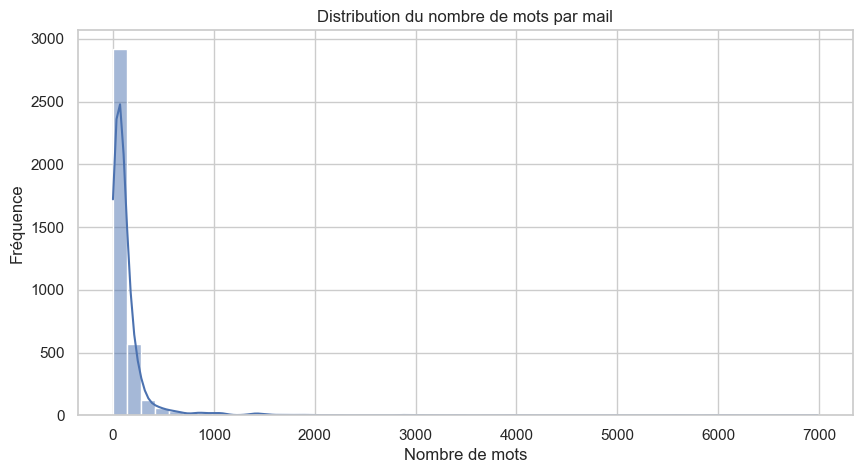

In [535]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df["N_WORDS"], bins=50, kde=True)
plt.title("Distribution du nombre de mots par mail")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


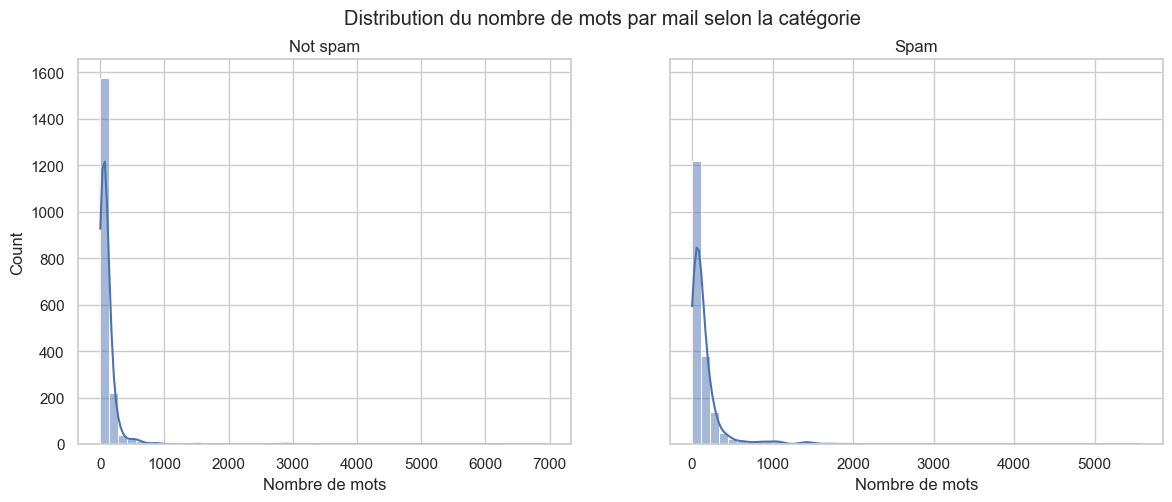

In [536]:
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

sns.histplot(
    df[df["CATEGORY"] == 0]["N_WORDS"],
    bins=50,
    kde=True,
    ax=axes[0]
)
axes[0].set_title("Not spam")
axes[0].set_xlabel("Nombre de mots")

sns.histplot(
    df[df["CATEGORY"] == 1]["N_WORDS"],
    bins=50,
    kde=True,
    ax=axes[1]
)
axes[1].set_title("Spam")
axes[1].set_xlabel("Nombre de mots")

plt.suptitle("Distribution du nombre de mots par mail selon la catégorie")
plt.show()


<br><br>
#### Fréquence des mots après prétraitement

Analyse des mots les plus fréquents après normalisation, tokenisation, suppression des stopwords et lemmatisation.

Cette analyse permet de :
- vérifier que le nettoyage a fonctionné correctement,
- identifier les termes dominants du corpus,
- repérer des mots fortement associés au spam.

Les fréquences observées dépendent directement :
- de la qualité du nettoyage,
- du choix des stopwords,
- de la présence ou non de la lemmatisation.


In [537]:
from collections import Counter

# =========================
# GLOBAL
# =========================

all_tokens = [
    token
    for tokens in df["TOKENS FINAL"]
    for token in tokens
]

counter_all = Counter(all_tokens)
top_all = counter_all.most_common(10)

# =========================
# NOT SPAM (CATEGORY = 0)
# =========================

tokens_not_spam = [
    token
    for tokens in df[df["CATEGORY"] == 0]["TOKENS FINAL"]
    for token in tokens
]

counter_not_spam = Counter(tokens_not_spam)
top_not_spam = counter_not_spam.most_common(10)

# =========================
# SPAM (CATEGORY = 1)
# =========================

tokens_spam = [
    token
    for tokens in df[df["CATEGORY"] == 1]["TOKENS FINAL"]
    for token in tokens
]

counter_spam = Counter(tokens_spam)
top_spam = counter_spam.most_common(10)

# =========================
# TABLE UNIQUE
# =========================

table = pd.DataFrame({
    "GLOBAL": [f"{w} ({c})" for w, c in top_all],
    "NOT_SPAM": [f"{w} ({c})" for w, c in top_not_spam],
    "SPAM": [f"{w} ({c})" for w, c in top_spam],
})

table




,GLOBAL,NOT_SPAM,SPAM
0,list (4168),list (2122),email (3074)
1,mail (3974),use (1568),mail (2746)
2,email (3710),get (1476),free (2743)
3,get (3520),one (1259),click (2085)
4,free (3087),say (1252),list (2046)
5,use (2979),mail (1228),get (2044)
6,one (2882),user (1210),make (1777)
7,make (2679),write (1115),send (1721)
8,time (2423),would (977),one (1623)
9,click (2134),time (930),business (1609)


In [538]:
liste_full = counter_all.most_common(5000)
liste_full


[('list', 4168),
 ('mail', 3974),
 ('email', 3710),
 ('get', 3520),
 ('free', 3087),
 ('use', 2979),
 ('one', 2882),
 ('make', 2679),
 ('time', 2423),
 ('click', 2134),
 ('send', 2120),
 ('new', 2015),
 ('work', 1945),
 ('information', 1814),
 ('people', 1793),
 ('business', 1761),
 ('money', 1752),
 ('message', 1749),
 ('please', 1725),
 ('net', 1721),
 ('like', 1718),
 ('would', 1672),
 ('order', 1671),
 ('receive', 1662),
 ('say', 1653),
 ('address', 1627),
 ('name', 1524),
 ('year', 1507),
 ('want', 1483),
 ('write', 1431),
 ('user', 1429),
 ('need', 1427),
 ('remove', 1423),
 ('find', 1396),
 ('day', 1391),
 ('see', 1369),
 ('company', 1363),
 ('site', 1358),
 ('take', 1312),
 ('think', 1300),
 ('also', 1298),
 ('know', 1287),
 ('state', 1269),
 ('call', 1216),
 ('offer', 1201),
 ('program', 1174),
 ('home', 1173),
 ('way', 1130),
 ('may', 1129),
 ('look', 1104),
 ('first', 1067),
 ('web', 1060),
 ('help', 1048),
 ('service', 1033),
 ('right', 1033),
 ('internet', 1029),
 ('even',

<br><br>
#### Comparaison du vocabulaire Spam / Non-Spam

Analyse comparative des mots les plus fréquents dans les emails Spam et Non-Spam.

Cette étape vise à mettre en évidence :
- des termes spécifiques à chaque classe,
- des différences de registre lexical,
- des mots à fort pouvoir discriminant.

Les résultats observés ici expliquent en grande partie
pourquoi des approches simples comme TF-IDF
sont souvent très performantes pour la détection de spam.

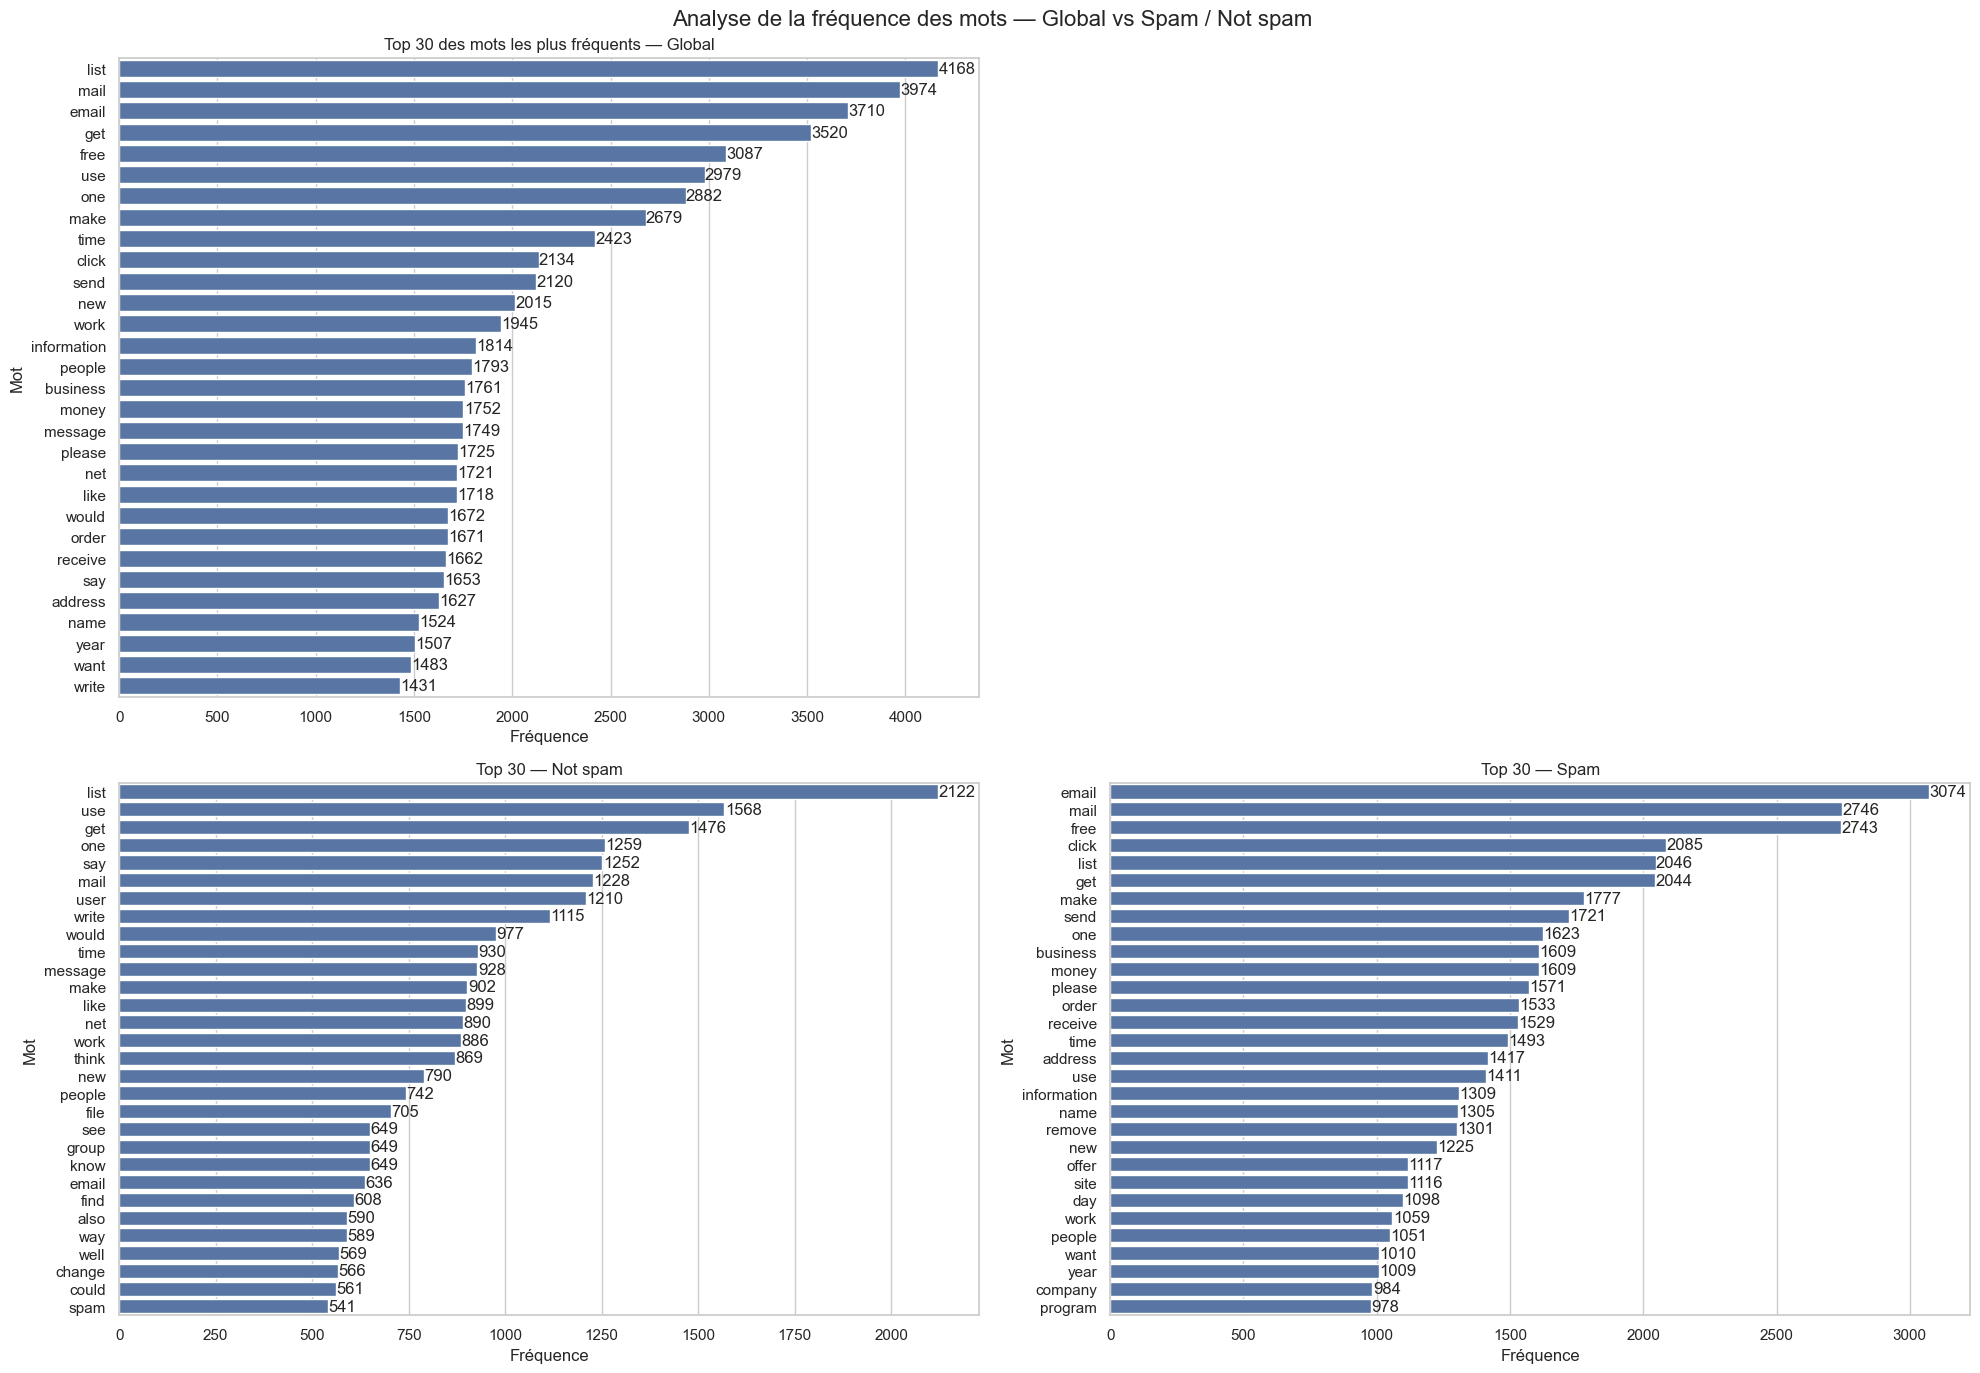

In [539]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# ==================================================
# 1) TOKENS GLOBAL
# ==================================================
tokens_all = [
    token
    for tokens in df["TOKENS FINAL"]
    for token in tokens
]

counter_all = Counter(tokens_all)
most_common_all = counter_all.most_common(30)
words_all, counts_all = zip(*most_common_all)


# ==================================================
# 2) TOKENS NOT SPAM
# ==================================================
tokens_not_spam = [
    token
    for tokens in df[df["CATEGORY"] == 0]["TOKENS FINAL"]
    for token in tokens
]

counter_not_spam = Counter(tokens_not_spam)
most_common_not_spam = counter_not_spam.most_common(30)
words_ns, counts_ns = zip(*most_common_not_spam)


# ==================================================
# 3) TOKENS SPAM
# ==================================================
tokens_spam = [
    token
    for tokens in df[df["CATEGORY"] == 1]["TOKENS FINAL"]
    for token in tokens
]

counter_spam = Counter(tokens_spam)
most_common_spam = counter_spam.most_common(30)
words_s, counts_s = zip(*most_common_spam)


# ==================================================
# 4) FIGURE : GLOBAL puis NOT SPAM / SPAM
# ==================================================
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(20, 14),
    gridspec_kw={"height_ratios": [1.2, 1]}
)

# --------------------------------------------------
# GLOBAL (ligne 1, colonne fusionnée)
# --------------------------------------------------
ax_global = axes[0, 0]
sns.barplot(
    x=list(counts_all),
    y=list(words_all),
    orient="h",
    ax=ax_global
)

for i, v in enumerate(counts_all):
    ax_global.text(v + 1, i, str(v), va="center")

ax_global.set_title("Top 30 des mots les plus fréquents — Global")
ax_global.set_xlabel("Fréquence")
ax_global.set_ylabel("Mot")

# Supprimer la cellule vide en haut à droite
fig.delaxes(axes[0, 1])


# --------------------------------------------------
# NOT SPAM (ligne 2 gauche)
# --------------------------------------------------
ax_ns = axes[1, 0]
sns.barplot(
    x=list(counts_ns),
    y=list(words_ns),
    orient="h",
    ax=ax_ns
)

for i, v in enumerate(counts_ns):
    ax_ns.text(v + 1, i, str(v), va="center")

ax_ns.set_title("Top 30 — Not spam")
ax_ns.set_xlabel("Fréquence")
ax_ns.set_ylabel("Mot")


# --------------------------------------------------
# SPAM (ligne 2 droite)
# --------------------------------------------------
ax_s = axes[1, 1]
sns.barplot(
    x=list(counts_s),
    y=list(words_s),
    orient="h",
    ax=ax_s
)

for i, v in enumerate(counts_s):
    ax_s.text(v + 1, i, str(v), va="center")

ax_s.set_title("Top 30 — Spam")
ax_s.set_xlabel("Fréquence")
ax_s.set_ylabel("Mot")


plt.suptitle("Analyse de la fréquence des mots — Global vs Spam / Not spam", fontsize=16)
plt.tight_layout()
plt.show()


<br><br>
#### Visualisation du vocabulaire global par WordCloud

On génère une visualisation de type *WordCloud* à partir du texte lemmatisé contenu dans la colonne `LEMMAS_TEXT`.

Le texte utilisé pour la WordCloud est construit en concaténant l’ensemble des emails du corpus en une seule chaîne de caractères. Chaque mot correspond donc à un lemme issu du pipeline NLP (normalisation, tokenisation, suppression des stopwords, lemmatisation).

La WordCloud permet de :
- visualiser rapidement les termes les plus fréquents du corpus,
- vérifier qualitativement que le prétraitement a supprimé le bruit (tokens techniques, résidus, artefacts),
- identifier les mots dominants après lemmatisation, indépendamment des classes.

Paramétrage important :
- `collocations=False` empêche l’affichage de bigrammes automatiques (ex. *mail list*, *one url*), afin de ne visualiser que des mots simples réellement présents dans le vocabulaire.
- `repeat=False` évite la répétition artificielle des mêmes mots dans la visualisation.
- la taille et le fond blanc sont choisis pour améliorer la lisibilité.

Cette visualisation est **exploratoire et qualitative** :
elle ne sert pas directement à la classification, mais permet de valider visuellement la cohérence du vocabulaire avant la modélisation ou l’analyse comparative par classe.


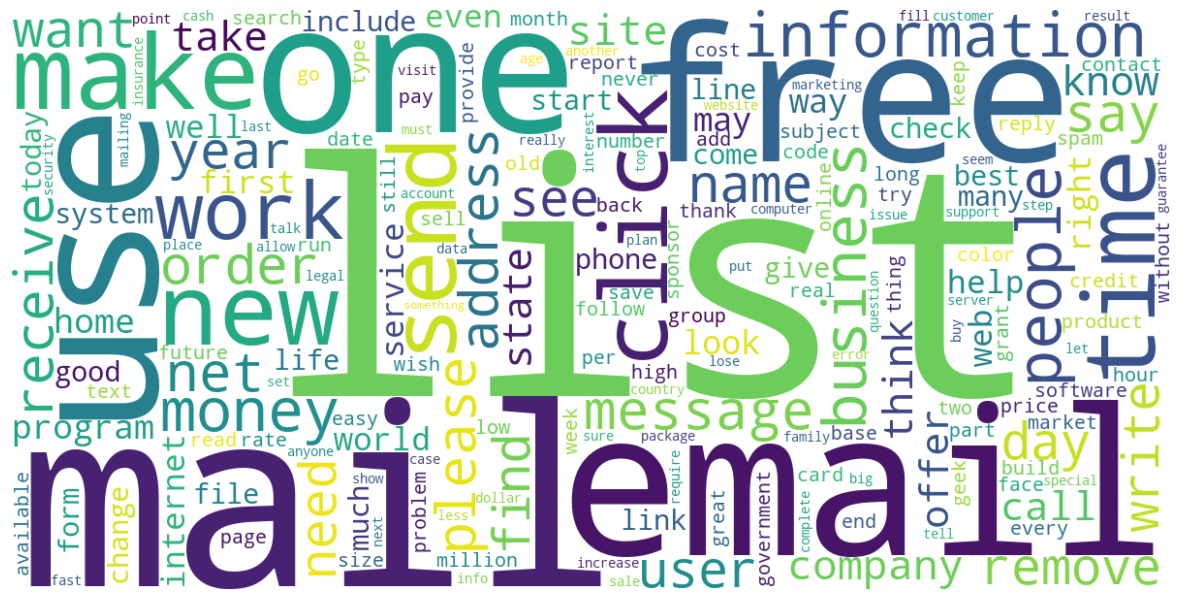

In [540]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text_for_wordcloud = " ".join(df["LEMMAS_TEXT"])
text_for_wordcloud = re.sub(r"\.", " ", text_for_wordcloud)

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    collocations=False,  # pas de bigrammes "mail list", "one url", etc.
    repeat=False         # ne redessine pas plusieurs fois le même mot
).generate(text_for_wordcloud)

plt.figure(figsize=(15, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


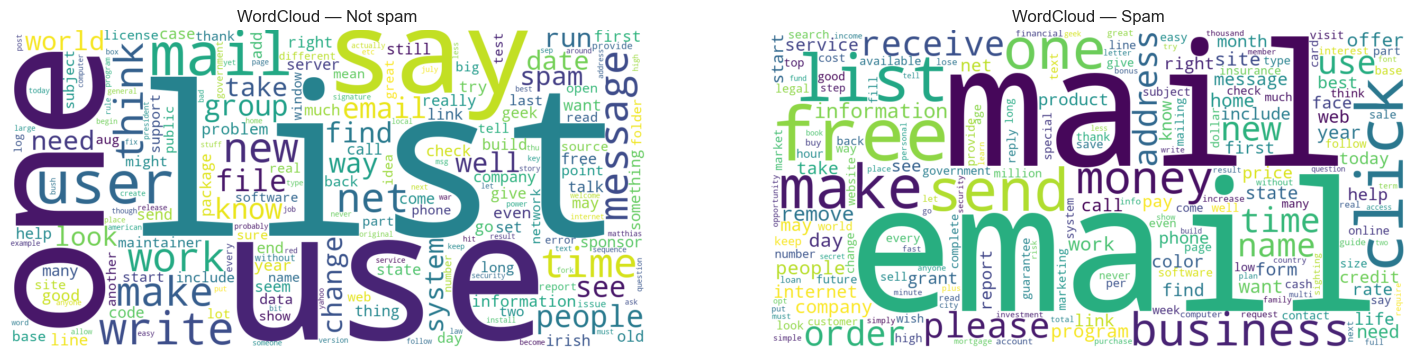

In [541]:
text_not_spam = " ".join(df[df["CATEGORY"] == 0]["LEMMAS_TEXT"])

wc_not_spam = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    collocations=False,
    repeat=False
).generate(text_not_spam)


text_spam = " ".join(df[df["CATEGORY"] == 1]["LEMMAS_TEXT"])

wc_spam = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    collocations=False,
    repeat=False
).generate(text_spam)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].imshow(wc_not_spam, interpolation="bilinear")
axes[0].set_title("WordCloud — Not spam")
axes[0].axis("off")

axes[1].imshow(wc_spam, interpolation="bilinear")
axes[1].set_title("WordCloud — Spam")
axes[1].axis("off")

plt.show()



<br><br>
#### Comparaison des longueurs des messages AVEC outliers (vue globale et par classe)

Cette analyse compare la distribution de la longueur des emails, mesurée par `N_WORDS`,
en conservant l’ensemble des observations, y compris les valeurs extrêmes.

Les boxplots présentés précédemment permettent d’observer :
- la médiane de la longueur des messages pour l’ensemble du corpus,
- les différences de distribution entre les classes *Spam* et *Not spam*,
- la présence et l’ampleur des valeurs aberrantes.

L’objectif de cette étape est de :
- comprendre l’influence des emails très courts ou très longs,
- évaluer si ces valeurs extrêmes sont spécifiques à une classe,
- disposer d’un point de référence avant tout filtrage.

Cette analyse reflète fidèlement la réalité brute des données
et sert de base de comparaison pour l’analyse sans outliers.


Global : 3792
Not spam : 1896
Spam : 1896


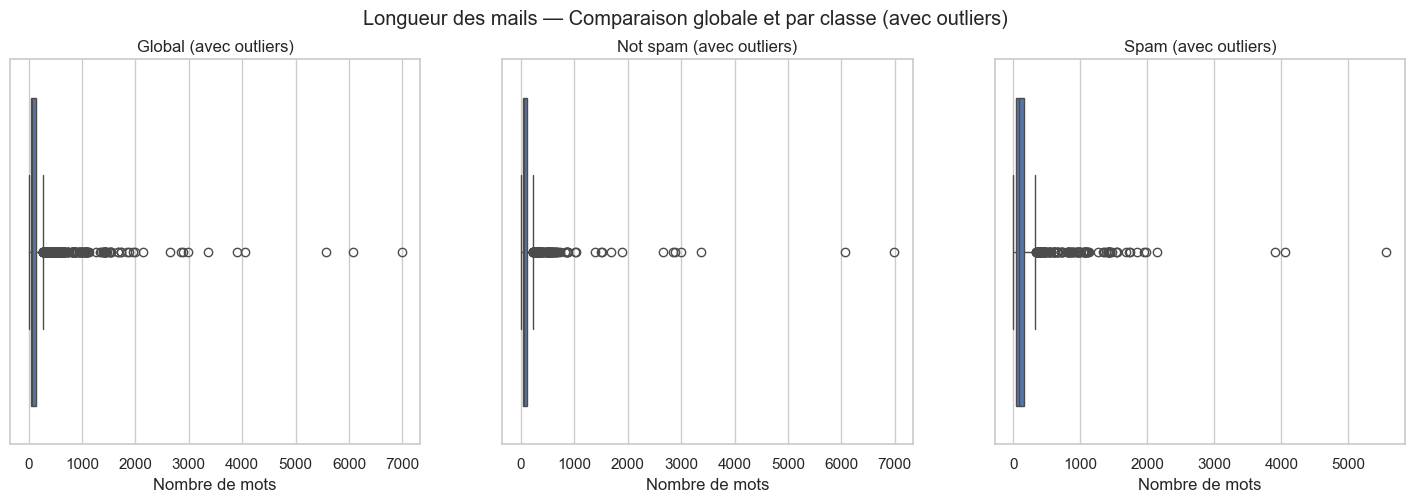

In [542]:
# --------------------------------------------------
# Séparation des données (AVEC outliers)
# Convention :
# 0 = Not spam
# 1 = Spam
# --------------------------------------------------
filtered_all = df
filtered_not_spam = df[df["CATEGORY"] == 0]
filtered_spam = df[df["CATEGORY"] == 1]


# --------------------------------------------------
# Vérification rapide des effectifs (sanity check)
# --------------------------------------------------
print("Global :", len(filtered_all))
print("Not spam :", len(filtered_not_spam))
print("Spam :", len(filtered_spam))


# --------------------------------------------------
# Boxplots côte à côte (AVEC outliers)
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.boxplot(x=filtered_all["N_WORDS"], ax=axes[0])
axes[0].set_title("Global (avec outliers)")

sns.boxplot(x=filtered_not_spam["N_WORDS"], ax=axes[1])
axes[1].set_title("Not spam (avec outliers)")

sns.boxplot(x=filtered_spam["N_WORDS"], ax=axes[2])
axes[2].set_title("Spam (avec outliers)")

for ax in axes:
    ax.set_xlabel("Nombre de mots")

plt.suptitle("Longueur des mails — Comparaison globale et par classe (avec outliers)")
plt.show()


<br><br>
#### Comparaison des longueurs des messages SANS outliers (vue globale et par classe)

Cette analyse compare la distribution de la longueur des emails après suppression des valeurs aberrantes,
à l’aide de la méthode IQR appliquée à la variable `N_WORDS`.

Les boxplots affichés pour :
- l’ensemble du corpus,
- la classe *Not spam*,
- la classe *Spam*,

permettent d’observer les distributions filtrées sur une échelle comparable.

L’objectif est de :
- isoler le comportement “typique” des emails,
- vérifier si les différences entre Spam et Not spam persistent sans valeurs extrêmes,
- évaluer si les outliers masquent ou amplifient artificiellement les écarts observés.

Cette étape permet de décider si un filtrage des outliers est pertinent
avant l’entraînement des modèles de classification.


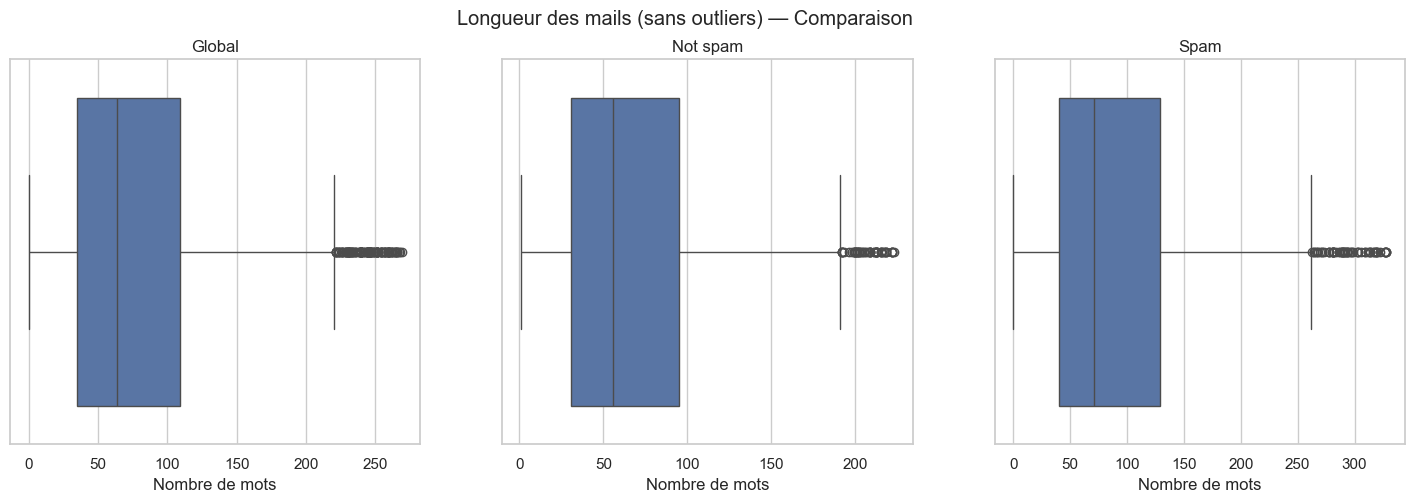

In [543]:
# --------------------------------------------------
# Function to remove outliers using IQR
# --------------------------------------------------
def remove_outliers_iqr(df_subset, column):
    Q1 = df_subset[column].quantile(0.25)
    Q3 = df_subset[column].quantile(0.75)
    IQR = Q3 - Q1
    return df_subset[
        (df_subset[column] >= Q1 - 1.5 * IQR) &
        (df_subset[column] <= Q3 + 1.5 * IQR)
    ]

# --------------------------------------------------
# Apply IQR filtering
# --------------------------------------------------
filtered_all = remove_outliers_iqr(df, "N_WORDS")
filtered_not_spam = remove_outliers_iqr(df[df["CATEGORY"] == 0], "N_WORDS")
filtered_spam = remove_outliers_iqr(df[df["CATEGORY"] == 1], "N_WORDS")

# --------------------------------------------------
# Boxplots side by side
# --------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.boxplot(x=filtered_all["N_WORDS"], ax=axes[0])
axes[0].set_title("Global")

sns.boxplot(x=filtered_not_spam["N_WORDS"], ax=axes[1])
axes[1].set_title("Not spam")

sns.boxplot(x=filtered_spam["N_WORDS"], ax=axes[2])
axes[2].set_title("Spam")

for ax in axes:
    ax.set_xlabel("Nombre de mots")

plt.suptitle("Longueur des mails (sans outliers) — Comparaison")
plt.show()

In [544]:
df["HAS_SINGLE_LETTER"] = df["TOKENS FINAL"].apply(
    lambda tokens: any(len(t) == 1 and t != "." for t in tokens)
)

df[df["HAS_SINGLE_LETTER"]]



,CATEGORY,MESSAGE,FILE_NAME,message_length,has_html,CLEANED,SENTENCES,TOKENS PRE,TOKENS,LEMMAS,TOKENS FINAL,LEMMAS_TEXT,BOW,TFIDF,W2V,BERT,N_WORDS,HAS_SINGLE_LETTER
53,1,<=21DOCTYPE HTML PUBLIC =22-//W3C//DTD HTML 4.0 Transitional//EN=22>\n\n<HTML><HEAD><TITLE></TITLE>\n\n<META http-equiv=3DContent-Type content=3D=22text/html; charset=3Dwindows-1=\n\n252=22>\n\n<STYLE>A:link =7B\n\n TEXT-DECORATION: none\n\n=7D\n\nA:active =7B\n\n TEXT-DECORATION: none\n\n...,00320.a4e760741d537aef50c4c0b950329225,5381,True,link text decoration none text decoration none text decoration none hover color text decoration underline for immediate release cal bay stock symbol cbyi watch for buy and sev eral advisory newsletters picking cbyi cbyi has filed traded the otcbb share prices increase when companies get listed t...,[link text decoration none text decoration none text decoration none hover color text decoration underline for immediate release cal bay stock symbol cbyi watch for buy and sev eral advisory newsletters picking cbyi cbyi has filed traded the otcbb share prices increase when companies get listed ...,"[[link, text, decoration, none, text, decoration, none, text, decoration, none, hover, color, text, decoration, underline, for, immediate, release, cal, bay, stock, symbol, cbyi, watch, for, buy, and, sev, eral, advisory, newsletters, picking, cbyi, cbyi, has, filed, traded, the, otcbb, share, p...","[[link, text, decoration, none, text, decoration, none, text, decoration, none, hover, color, text, decoration, underline, immediate, release, cal, bay, stock, symbol, cbyi, watch, buy, sev, eral, advisory, newsletters, picking, cbyi, cbyi, filed, traded, otcbb, share, prices, increase, companie...","[[link, text, decoration, none, text, decoration, none, text, decoration, none, hover, color, text, decoration, underline, immediate, release, cal, bay, stock, symbol, cbyi, watch, buy, sev, eral, advisory, newsletter, pick, cbyi, cbyi, file, trade, otcbb, share, price, increase, company, get, l...","[link, text, decoration, none, text, decoration, none, text, decoration, none, hover, color, text, decoration, underline, immediate, release, cal, bay, stock, symbol, cbyi, watch, buy, sev, eral, advisory, newsletter, pick, cbyi, cbyi, file, trade, otcbb, share, price, increase, company, get, li...",link text decoration none text decoration none text decoration none hover color text decoration underline immediate release cal bay stock symbol cbyi watch buy sev eral advisory newsletter pick cbyi cbyi file trade otcbb share price increase company get list large trading exhange cbyi trading ar...,"(0, 9602)\t1\n (0, 14308)\t1\n (0, 15949)\t1\n (0, 8982)\t1\n (0, 13963)\t1\n (0, 16712)\t1\n (0, 7450)\t1\n (0, 4461)\t1\n (0, 23779)\t1\n (0, 18502)\t1\n (0, 18604)\t1\n (0, 9118)\t1\n (0, 13751)\t1\n (0, 14639)\t1\n (0, 15887)\t1\n (0, 13787)\t3\n (0, 26127)\t2\n (0, 14462)...","(0, 9602)\t0.019008592705354797\n (0, 14308)\t0.02306661044289827\n (0, 15949)\t0.036883115674361915\n (0, 8982)\t0.03039025415362922\n (0, 13963)\t0.02772120477916647\n (0, 16712)\t0.021208390240366463\n (0, 7450)\t0.033446044792651404\n (0, 4461)\t0.04520077591917197\n (0, 23779)\t0....","[0.09382631629705429, 0.18204617500305176, -0.011903169564902782, 0.12824620306491852, -0.1632951945066452, -0.5128682255744934, -0.17875617742538452, 0.5034880638122559, 0.05612049996852875, 0.1111736074090004, -0.09002078324556351, -0.47274085879325867, -0.09829443693161011, 0.1352471709251403...","[0.005215178, -0.04389276, -0.033697363, 0.041914072, -0.014716456, 0.02761171, 0.042117782, -0.0008560124, -0.015718574, -0.035204947, 0.034310006, -0.026373133, 0.035215016, -0.079749405, 0.033993907, 0.034805328, 0.07000359, 0.008233962, -0.078483276, -0.024992803, -0.0041864566, -0.012570206...",246,True
112,1,\n\n<HTML>\n\n<HEAD>\n\n <TITLE>\n\n </TITLE>\n\n<META http-equiv=3D=22Content-Type=22 content=3D=22text/html; charset=3Dwindo=\n\nws-1252=22>\n\n <STYLE>\n\nA:link =7B\n\n TEXT-DECORAT

---
<br><br><br>

# 10. Topic Modeling (LDA) on Emails

Le *Topic Modeling* est une technique de traitement du langage naturel **non supervisée** dont l’objectif est d’identifier automatiquement les principaux **thèmes latents** présents dans un corpus de documents.

Dans ce notebook, chaque **email** est considéré comme un document. Le but n’est pas de prédire une classe (Spam / Not spam),
mais d’explorer la structure thématique globale du corpus.

Les topics extraits peuvent correspondre, par exemple, à :
- des emails promotionnels ou commerciaux,
- des messages techniques ou automatisés,
- des notifications, confirmations ou mailing lists.

Cette approche permet de mieux comprendre le contenu du dataset et d’identifier des régularités sémantiques indépendamment des labels.


#### Préparation du corpus pour le LDA

Avant d’appliquer un modèle LDA, les emails doivent être représentés sous une forme adaptée au topic modeling.

Le corpus utilisé repose sur le texte prétraité issu du pipeline NLP (normalisation, tokenisation, suppression des stopwords et lemmatisation), ce qui permet de réduire le bruit, de stabiliser le vocabulaire et d’améliorer la cohérence des topics extraits.

Chaque email est ainsi représenté comme une séquence de tokens nettoyés, servant de base à la modélisation thématique.


#### Construction du dictionnaire et du corpus Bag-of-Words

Cette étape consiste à construire un dictionnaire associant chaque token unique à un identifiant numérique, ainsi qu’un corpus Bag-of-Words représentant chaque email sous forme de couples (identifiant du token, fréquence).

Cette représentation ignore l’ordre des mots et se concentre uniquement sur leur fréquence d’apparition dans chaque email.

Le dictionnaire et le corpus constituent la base mathématique nécessaire à l’entraînement du modèle LDA.


In [545]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import gensim
import warnings
warnings.filterwarnings("ignore")

# Tokens finals
texts = df["TOKENS FINAL"].tolist()

# Create dictionary
dictionary = Dictionary(texts)

# Remove very rare and very frequent tokens
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Corpus (bag of words format)
corpus = [dictionary.doc2bow(text) for text in texts]


<br><br>
#### Entraînement du modèle LDA

Le modèle LDA est entraîné sur le corpus Bag-of-Words afin d’identifier un ensemble de topics latents présents dans les emails.

Chaque topic correspond à une distribution de probabilité sur les mots du vocabulaire, tandis que chaque email est représenté comme une distribution de probabilité sur ces topics.

Le nombre de topics est un paramètre exploratoire important, choisi de manière empirique afin de trouver un compromis entre interprétabilité des thèmes et niveau de détail.



In [546]:
NUM_TOPICS = 5

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    passes=15,
    random_state=42
)


<br><br>
#### Interprétation des topics extraits

Une fois le modèle entraîné, chaque topic est analysé à partir des mots les plus représentatifs qui lui sont associés.

Cette interprétation est qualitative et vise à attribuer une signification sémantique à chaque topic, par exemple des emails promotionnels, des messages techniques, des notifications automatisées ou des contenus typiquement associés au spam.

Cette étape permet de mieux comprendre la structure thématique globale du corpus.


In [547]:
for i, topic in lda_model.show_topics(num_topics=NUM_TOPICS, formatted=False):
    print(f"\n--- Topic {i} ---")
    print(" | ".join([word for word, prob in topic]))



--- Topic 0 ---
one | company | say | state | year | world | use | government | would | time

--- Topic 1 ---
get | make | money | people | free | business | send | one | order | work

--- Topic 2 ---
email | color | site | click | face | list | web | mail | size | use

--- Topic 3 ---
list | user | mail | use | net | get | write | message | file | think

--- Topic 4 ---
click | free | mail | email | remove | receive | please | list | rate | credit


<br><br>
#### Visualisation et exploration des topics

Les résultats du LDA peuvent être visualisés afin de faciliter leur interprétation.

Ces visualisations permettent d’examiner la composition des topics, de comparer les thèmes entre eux et d’observer leur répartition au sein des emails.

Elles constituent un outil essentiel pour l’analyse d’un modèle non supervisé, dont les résultats ne sont pas directement évaluables par des métriques classiques.


In [548]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.039967  0.029213       1        1  28.211532
0     -0.126028  0.133096       2        1  23.674241
3     -0.117320 -0.173955       3        1  19.423551
4      0.112747  0.077028       4        1  17.522798
2      0.170568 -0.065380       5        1  11.167878, topic_info=            Term         Freq        Total Category  logprob  loglift
105        email  3638.000000  3638.000000  Default  30.0000  30.0000
101        click  2121.000000  2121.000000  Default  29.0000  29.0000
158         list  4161.000000  4161.000000  Default  28.0000  28.0000
103        color   841.000000   841.000000  Default  27.0000  27.0000
140         site  1367.000000  1367.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
387        right   256.319548  1017.660983   Topic5  -5.3014   0.8133
350        order   265.558754  1623.204558   Topic5  -5.2660   0.3818
37          find   249.457897  1374.625168   Topic5  -5.3285   0.4855
322         send   264.728130  2088.921282   Topic5  -5.2691   0.1264
304  information   250.129786  1788.120623   Topic5  -5.3259   0.2252

[427 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
599       1  0.071873     act
599       2  0.612255     act
599       3  0.021296     act
599       4  0.260874     act
599       5  0.031944     act
...     ...       ...     ...
288       3  0.004723    year
288       4  0.276633    year
288       5  0.028338    year
3998      1  0.050603  yellow
3998      5  0.927717  yellow

[965 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

<br><br>
#### Limites et rôle du Topic Modeling dans ce notebook

Le Topic Modeling présente certaines limites dans le cadre de la détection de spam.

Il s’agit d’une approche non supervisée qui n’exploite pas les labels Spam / Not spam, l’interprétation des topics reste subjective et les résultats dépendent fortement des paramètres choisis ainsi que de la taille du corpus.

Dans ce notebook, le LDA est utilisé comme un outil exploratoire et non comme un composant direct du modèle de classification.


In [549]:
def get_main_topic(lda_model, bow):
    topics = lda_model.get_document_topics(bow)
    topics = sorted(topics, key=lambda x: x[1], reverse=True)
    return topics[0][0] if topics else None

df["MAIN_TOPIC"] = [get_main_topic(lda_model, bow) for bow in corpus]
df[["MESSAGE", "MAIN_TOPIC"]].head()


,MESSAGE,MAIN_TOPIC
0,"<HTML>\n\n<HEAD>\n\n</HEAD>\n\n<BODY>\n\n<FONT SIZE=3D""4""><B> A man endowed with a 7 - 8"" hammer is simply<br>\n\n better equipped than a man with a 5 - 6"" hammer. <BR>\n\n<BR>Would you rather have<br>more than enough to get the job done or fall =\n\nvery short. It's totally up<br>to you. Our Me...",1
1,"\n\n>>> Tim Peters wrote\n\n> We've not only reduced the f-p and f-n rates in my test runs, we've also\n\n> made the score distributions substantially sharper. This is bad news for\n\n> Greg, because the non-existent ""middle ground"" is becoming even less\n\n> existent <wink>:\n\n\n\nWell, I've ...",3
2,"<html>\n\n<head>\n\n<title>New amazing incest show on Hot-Babies-Live.Com</title>\n\n<meta http-equiv=""Content-Type"" content=""text/html; charset=windows-1252"">\n\n</head>\n\n<body bgcolor=#000000 text=#000000 link=#000000 vlink=#000000 alink=""#ff0000"" topmargin=0 leftmargin=0 rightmargin=0 botto...",4
3,"Hiya, I just myself an rpm, and when I did -Uvh to upgrade the earlier \n\nversion I had installed (also from my rpm) I got:\n\n\n\n[root@spawn i386]# rpm -Uvh mulberry-2.2-b1.i386.rpm\n\nPreparing... ########################################### \n\n[100%]\n\n 1:mulberry ...",3
4,"Well, it looks like Sun are going ahead with\n\ntheir ubiquitous computing plans without Mithril. \n\n\n\nGreg\n\n\n\nReuters Market News\n\n Sun Micro Outlines Roadmap for Managing Networks \n\n Friday September 20, 5:00 am ET \n\n By Peter Henderson \n\n\n\n SAN FRANCISCO (Reuters) - Compu...",0


---
<br><br><br>


# 11. Machine Learning Supervisé — Classification des emails


L’objectif de cette étape est de construire un modèle de **Machine Learning supervisé** capable de prédire si un email est un **spam** ou un **non-spam** à partir de son contenu textuel.

La variable cible est définie comme suit :
- **0** : Not spam
- **1** : Spam

Les emails ont été préalablement nettoyés (suppression du bruit, normalisation, lemmatisation) afin de garantir une représentation textuelle exploitable par les modèles.



In [550]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

X = df["LEMMAS_TEXT"]
y = df["CATEGORY"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)



#### Évaluation du modèle SVM

Les performances du modèle sont évaluées à l’aide des métriques classiques de classification.

In [551]:
print("Accuracy :", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Accuracy : 0.9881422924901185
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       380
           1       0.99      0.99      0.99       379

    accuracy                           0.99       759
   macro avg       0.99      0.99      0.99       759
weighted avg       0.99      0.99      0.99       759



---
<br><br><br>

# 12. Réseau de Neurones — Approche Deep Learning

Cette partie explore une approche Deep Learning basée sur un réseau de neurones
dense afin de comparer ses performances avec le modèle SVM.


In [552]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history = model.fit(
    X_train_tfidf.toarray(),
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)
y_pred_nn = (model.predict(X_test_tfidf.toarray()) > 0.5).astype(int)



Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9060 - loss: 0.3605 - val_accuracy: 0.9769 - val_loss: 0.0664
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9922 - loss: 0.0288 - val_accuracy: 0.9852 - val_loss: 0.0363
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9984 - loss: 0.0097 - val_accuracy: 0.9868 - val_loss: 0.0288
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9996 - loss: 0.0049 - val_accuracy: 0.9885 - val_loss: 0.0268
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9996 - loss: 0.0035 - val_accuracy: 0.9852 - val_loss: 0.0385
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9852 - val_loss: 0.0382
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9852 - val_loss: 0.0389
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 1.0000 - loss: 7.1655e-04 - val_accuracy: 0.9885

#### Évaluation du réseau de neurones

Les métriques suivantes permettent d’évaluer la qualité du modèle neuronal en comparaison avec le SVM.


In [553]:
print("Accuracy :", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))


Accuracy : 0.9828722002635046
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       380
           1       0.97      0.99      0.98       379

    accuracy                           0.98       759
   macro avg       0.98      0.98      0.98       759
weighted avg       0.98      0.98      0.98       759



---
<br><br><br>
# 13. Réseau LSTM — Modélisation séquentielle

Contrairement aux approches précédentes, le modèle LSTM prend en compte l’ordre des mots dans les emails afin de capturer le contexte sémantique.


In [554]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["LEMMAS_TEXT"])

sequences = tokenizer.texts_to_sequences(df["LEMMAS_TEXT"])
X_seq = pad_sequences(sequences, maxlen=200)

y = df["CATEGORY"]

X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y, test_size=0.2, random_state=42, stratify=y
)


lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=200),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

lstm_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.8578 - loss: 0.3566 - val_accuracy: 0.9786 - val_loss: 0.0925
Epoch 2/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9868 - loss: 0.0522 - val_accuracy: 0.9786 - val_loss: 0.0475
Epoch 3/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.9926 - loss: 0.0393 - val_accuracy: 0.9802 - val_loss: 0.0695
Epoch 4/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9946 - loss: 0.0322 - val_accuracy: 0.9868 - val_loss: 0.0430
Epoch 5/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9975 - loss: 0.0142 - val_accuracy: 0.9819 - val_loss: 0.0726
Epoch 6/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - accuracy: 0.9992 - loss: 0.0077 - val_accuracy: 0.9852 - val_loss: 0.0440
Epoch 7/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 0.9819 - val_loss: 0.0628
Epoch 8/10
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accur

#### Évaluation du réseau LSTM

Les métriques suivantes permettent d’évaluer la qualité de LSTM

In [555]:
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype(int)

print("Accuracy :", accuracy_score(y_test, y_pred_lstm))
print(classification_report(y_test, y_pred_lstm))


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Accuracy : 0.9855072463768116
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       380
           1       0.98      0.99      0.99       379

    accuracy                           0.99       759
   macro avg       0.99      0.99      0.99       759
weighted avg       0.99      0.99      0.99       759



---
<br><br><br>

# 14. Résultats et tests

Les performances des trois approches (SVM, réseau de neurones classique et LSTM) ont été évaluées à l’aide des métriques standards de classification : Accuracy, Precision, Recall et F1-score.

### Résultats quantitatifs

| Modèle                   | Accuracy | Precision (Spam) | Recall (Spam) | F1-score (Spam) |
|--------------------------|----------|------------------|---------------|------------------|
| SVM (LinearSVC)          | 0.9881   | 0.99             | 0.99          | 0.99             |
| Réseau de neurones (MLP) | 0.9829   | 0.97             | 0.99          | 0.98             |
| LSTM                     | 0.9868   | 0.98             | 0.99          | 0.99             |

---

### Analyse et interprétation

Le modèle **SVM** obtient la meilleure accuracy globale (≈ 98.8 %) ainsi que des scores de précision, rappel et F1-score très élevés et équilibrés pour la classe *Spam*. Il s’impose comme le modèle le plus performant tout en restant simple, robuste et rapide à entraîner.

Le **réseau de neurones classique (MLP)** présente des performances légèrement inférieures à celles du SVM, avec une accuracy autour de 98.3 %. Bien que son rappel sur la classe *Spam* soit élevé, sa précision est plus faible, ce qui indique davantage de faux positifs. Sa complexité supplémentaire n’apporte donc pas de gain significatif sur ce jeu de données.

Le modèle **LSTM**, conçu pour capturer les dépendances séquentielles du texte, affiche des performances comparables au SVM avec une accuracy proche de 98.7 %. Toutefois, l’amélioration reste marginale au regard du coût computationnel nettement plus élevé, ce qui limite son intérêt pratique dans ce contexte.


In [556]:
def predict_spam_svm(text, model, vectorizer):
    cleaned_text = clean_text(text)
    text_tfidf = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_tfidf)[0]
    return "SPAM" if prediction == 1 else "NOT SPAM"


In [557]:
message = """
Congratulations! You have been selected to receive a free gift card.
Click the link below to claim it.
"""

result = predict_spam_svm(message, svm_model, tfidf)
print(result)


SPAM


In [558]:
message = """
Hi team,

Please find the report attached.
Let me know if you have any questions.

Best regards,
David
"""

result = predict_spam_svm(message, svm_model, tfidf)
print(result)


NOT SPAM


---
<br><br><br>

# Conclusion générale

Dans le cadre de la classification de spams basée sur des représentations TF-IDF et un nettoyage lexical approfondi :

- Le SVM constitue le meilleur compromis entre performance, simplicité et efficacité.
- Les réseaux de neurones (MLP et LSTM) n’apportent pas d’amélioration significative pour ce type de données.
- L’utilisation d’un LSTM n’est pas justifiée sans embeddings sémantiques plus riches ou un volume de données plus important.

Ainsi, le SVM est retenu comme modèle final pour la détection de spams dans cette étude.

<br><br><br>